In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import io
from PIL import Image
import glob
import os
import pandas as pd
import matplotlib
matplotlib.style.use('dark_background')
import re
import seaborn as sns
import sys
from datetime import datetime, timedelta
sys.path.append('E:/')
from function import *
import h5py

In [2]:
# Main processing loop for multiple files
pc = 'sophia'
if pc == 'sophia':
    basevol='C:/Seafile/'
    basepath = basevol + '/BSc_data/'
    data_info = basepath + '/data_info/'
    output_folder = basepath + "/processed_data/"
    npz_directory = basepath + 'shark_tracking_data/'
    figures_path = basepath + "figures/"
    mat_file_path = basepath + 'carangids_manual_tracking/tracking/'
else:
    basevol = '/Users/ang/Seafile/'
    basepath = basevol + '/BSc_data/'
    data_info = basepath + '/data_info/'
    output_folder = basepath + "/processed_data/"
    npz_directory = basepath + 'shark_tracking_data/'
    figures_path = basepath + "figures/"
    mat_file_path = basepath + 'carangids_manual_tracking/tracking/'

### define some columns lists

In [3]:
midpoints = [('headx', 'heady'),('btipx', 'btipy'), ('pelvicfinx', 'pelvicfiny'), ('sdfinx', 'sdfiny'), ('pedunclex', 'peduncley'), ('finx','finy'), ('ttipx', 'ttipy')]
midpoints_centered = [('centered_headx', 'centered_heady'),('centered_btipx', 'centered_btipy'), ('centered_pelvicfinx', 'centered_pelvicfiny'), ('centered_sdfinx', 'centered_sdfiny'), ('centered_pedunclex', 'centered_peduncley'), ('centered_finx','centered_finy'), ('centered_ttipx', 'centered_ttipy')]
midpoints_rotated = [('rotated_headx', 'rotated_heady'),('rotated_btipx', 'rotated_btipy'), ('rotated_pelvicfinx', 'rotated_pelvicfiny'), ('rotated_sdfinx', 'rotated_sdfiny'), ('rotated_pedunclex', 'rotated_peduncley'), ('rotated_finx','rotated_finy'), ('rotated_ttipx', 'rotated_ttipy')]
joints_to_plot = [f'angle_joint_{i}' for i in range(6)]

In [8]:
sharks_df = pd.read_hdf(output_folder + "subset_sharks.h5", key='sharks')

In [9]:
sharks_df.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0      0         0.000000   0  -597.556030    30.503662 -0.614673      0   
1      1       246.525452   0  -601.888000    31.994019 -0.616159      1   
2      2       301.757548   0  -605.915649    33.496460 -0.620030      2   
3      3       317.241776   0  -609.988617    34.644623 -0.621046      3   
4      4       339.523218   0  -613.667163    35.803613 -0.629249      4   

   time        headx        heady  ...          Y  segment  \
0  0.00  1982.000000  1478.000000  ...  30.503662        1   
1  0.01  1976.500000  1479.500000  ...  31.994019        1   
2  0.02  1972.333333  1480.333333  ...  33.496460        1   
3  0.03  1968.000000  1481.500000  ...  34.644623        1   
4  0.04  1963.800000  1482.400000  ...  35.803613        1   

                                  Trial   midpoint_x  midpoint_y  carangids  \
0  sequence_20240306_161443984_DJI_0139  1950.000000    1502.000          1   
1  sequence_20240306_161443984_DJI_0139  1945.500000    1502.750          1   
2  sequence_20240306_161443984_DJI_0139  1941.666667    1503.500          1   
3  sequence_20240306_161443984_DJI_0139  1937.500000    1504.625          1   
4  sequence_20240306_161443984_DJI_0139  1933.500000    1505.700          1   

   drone_movement  ID_checked  smoothed_unique_id_count  unique_id_count  
0               1         1.0                       2.0              2.0  
1               1         1.0                       2.0              2.0  
2               1         1.0                       2.0              2.0  
3               1         1.0                       2.0              2.0  
4               1         1.0                       2.0              2.0  

[5 rows x 37 columns]

### pairwise distance and NN distance

In [10]:
# Group by both 'ID' and 'segment' and count the number of frames for each group
id_segment_counts = sharks_df.groupby(['ID', 'segment']).size()

# Filter out ID-segment combinations that have less than 100 frames (2 seconds)
id_segments_to_keep = id_segment_counts[id_segment_counts >= 100].index

# Keep only the rows where the combination of 'ID' and 'segment' is in the list of groups with >= 100 frames
sharks_df = sharks_df[sharks_df.set_index(['ID', 'segment']).index.isin(id_segments_to_keep)]

In [11]:
sharks_df_filtered = sharks_df[(sharks_df['ID_checked'] == 1) & (sharks_df['drone_movement'] == 0)]

In [12]:
subset = sharks_df_filtered[['ID', 'frame', 'midpoint_x', 'midpoint_y', 'carangids', 'Trial', 'segment', 'unique_id_count']]
subset.head()

ID  frame   midpoint_x   midpoint_y  carangids  \
2051   0   2051  3147.875000  1082.916667          1   
2052   0   2052  3149.708333  1083.125000          1   
2053   0   2053  3151.458333  1083.250000          1   
2054   0   2054  3153.125000  1083.333333          1   
2055   0   2055  3154.750000  1083.416667          1   

                                     Trial  segment  unique_id_count  
2051  sequence_20240306_161443984_DJI_0139        1              2.0  
2052  sequence_20240306_161443984_DJI_0139        1              2.0  
2053  sequence_20240306_161443984_DJI_0139        1              2.0  
2054  sequence_20240306_161443984_DJI_0139        1              2.0  
2055  sequence_20240306_161443984_DJI_0139        1              2.0

In [13]:
# Step 1: Initialize an empty DataFrame to collect results across sequences
all_results = pd.DataFrame()

# Iterate over each unique trial sequence
for trial in subset['Trial'].unique():
    # Filter the subset to the current trial
    trial_subset = subset[subset['Trial'] == trial]
    
    # Prepare necessary variables for this specific trial
    fishlist = np.unique(trial_subset["ID"].values)
    maxframe = len(np.unique(trial_subset["frame"].values))
    num_individuals = len(fishlist)
    
    # Initialize arrays for pairwise distances, nearest neighbor indices, and minimum distances
    pairwise_df = np.zeros((num_individuals, num_individuals, maxframe))
    nearest_neighbors = np.full((num_individuals, maxframe), -1, dtype=int)
    mindist = np.full((num_individuals, maxframe), np.nan)
    
    # Collect all unique frames in the trial and create a dictionary to store aligned coordinates
    all_frames = np.unique(trial_subset["frame"].values)
    aligned_coords = {}

    # Align frames for each fish (set coordinates to NaN for missing frames)
    for ixff, fish in enumerate(fishlist):
        ff_ = trial_subset[trial_subset["ID"] == fish].set_index("frame").reindex(all_frames)
        aligned_coords[fish] = np.vstack((ff_["midpoint_x"].values, ff_["midpoint_y"].values)).T

    # Step 3: Calculate pairwise distances across all frames for the current trial
    for ixff, fish in enumerate(fishlist):
        for ixnf, nf in enumerate(fishlist):
            if fish != nf:
                # Calculate pairwise distances only for frames where both have coordinates
                valid_mask = ~np.isnan(aligned_coords[fish][:, 0]) & ~np.isnan(aligned_coords[nf][:, 0])
                distances = np.full(maxframe, np.nan)
                
                # Compute distance for valid frames
                distances[valid_mask] = np.linalg.norm(
                    aligned_coords[fish][valid_mask] - aligned_coords[nf][valid_mask], axis=1
                )
                pairwise_df[ixff, ixnf, :] = distances

    # Step 4: Handle NaN values by setting diagonal and applying mask across frames
    for i in range(maxframe):
        np.fill_diagonal(pairwise_df[:, :, i], np.nan)  # Ignore self distances
    
    # Calculate the all-NaN mask across frames for the current trial
    all_nan_mask = np.all(np.isnan(pairwise_df), axis=2)
    for i in range(maxframe):
        pairwise_df[:, :, i][all_nan_mask] = np.nan  # Keep NaN if all neighbors are NaN

    # Step 5: Compute nearest neighbor and distance
    for i in range(pairwise_df.shape[2]):
        # Set diagonal to np.nan to ignore distances to self
        temp_matrix = pairwise_df[:, :, i].copy()
        np.fill_diagonal(temp_matrix, np.nan)

        # Find the index of the minimum (nearest neighbor) for each fish (excluding itself)
        valid_mask = ~np.isnan(temp_matrix).all(axis=1)  # mask for non-NaN rows
        
        if np.any(valid_mask):
            nearest_neighbors[valid_mask, i] = np.nanargmin(temp_matrix[valid_mask], axis=1)
            mindist[valid_mask, i] = np.nanmin(temp_matrix[valid_mask], axis=1)
    
    # Step 6: Create a DataFrame with nearest neighbor information for the current trial
    trial_results_df = pd.DataFrame({
        "ID": np.repeat(fishlist, maxframe),
        "frame": np.tile(all_frames, num_individuals),
        "nearest_neighbor": fishlist[nearest_neighbors.flatten()],
        "nn_distance": mindist.flatten(),
        "Trial": trial  # Add the Trial column to identify sequences
    })

    # Step 7: If the nearest neighbor distance is NaN, set it to the fish's own ID (in case of missing data)
    trial_results_df["nearest_neighbor"] = np.where(
        trial_results_df["nn_distance"].isna(), trial_results_df["ID"], trial_results_df["nearest_neighbor"]
    )

    # Append the results for this trial to the all_results DataFrame
    all_results = pd.concat([all_results, trial_results_df], ignore_index=True)

# Drop any existing 'nearest_neighbor' and 'nn_distance' columns before merging to avoid duplicates
subset = subset.drop(columns=["nearest_neighbor", "nn_distance"], errors='ignore')

# Step 8: Merge all_results back into subset
subset = pd.merge(subset, all_results, on=["ID", "frame", "Trial"], how="left")

# Display the result
print(subset)

         ID  frame   midpoint_x   midpoint_y  carangids  \
0         0   2051  3147.875000  1082.916667          1   
1         0   2052  3149.708333  1083.125000          1   
2         0   2053  3151.458333  1083.250000          1   
3         0   2054  3153.125000  1083.333333          1   
4         0   2055  3154.750000  1083.416667          1   
...      ..    ...          ...          ...        ...   
1082068   2  57945          NaN          NaN          0   
1082069   2  57946          NaN          NaN          0   
1082070   2  57947          NaN          NaN          0   
1082071   2  57948          NaN          NaN          0   
1082072   2  57949          NaN          NaN          0   

                                        Trial  segment  unique_id_count  \
0        sequence_20240306_161443984_DJI_0139        1              2.0   
1        sequence_20240306_161443984_DJI_0139        1              2.0   
2        sequence_20240306_161443984_DJI_0139        1            

In [14]:
# Save sharks_df to HDF5
sharks_output_file = os.path.join(output_folder, "nn_sharks.h5")
subset.to_hdf(sharks_output_file, key='sharks', mode='w')
print(f"Shark data saved to {sharks_output_file}")

Shark data saved to E:/sophia/shark_data/processed_data/nn_sharks.h5


### Standardizing of nearest neighbour distance

In [15]:
sharks_nn = pd.read_hdf(output_folder + "nn_sharks.h5", key='sharks')
sharks_nn.head()

ID  frame   midpoint_x   midpoint_y  carangids  \
0   0   2051  3147.875000  1082.916667          1   
1   0   2052  3149.708333  1083.125000          1   
2   0   2053  3151.458333  1083.250000          1   
3   0   2054  3153.125000  1083.333333          1   
4   0   2055  3154.750000  1083.416667          1   

                                  Trial  segment  unique_id_count  \
0  sequence_20240306_161443984_DJI_0139        1              2.0   
1  sequence_20240306_161443984_DJI_0139        1              2.0   
2  sequence_20240306_161443984_DJI_0139        1              2.0   
3  sequence_20240306_161443984_DJI_0139        1              2.0   
4  sequence_20240306_161443984_DJI_0139        1              2.0   

   nearest_neighbor  nn_distance  
0                 1   696.033544  
1                 1   698.254526  
2                 1   700.389238  
3                 1   702.533543  
4                 1   704.553259

In [16]:
sharks_speed = pd.read_hdf(output_folder + "speed_sharks.h5", key='sharks')
sharks_speed.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0   9677       100.645049   0          NaN          NaN -1.390408   9677   
1   9678       100.709486   0          NaN          NaN -1.412380   9678   
2   9679       104.044606   0          NaN          NaN -1.427205   9679   
3   9680        90.505609   0          NaN          NaN -1.436478   9680   
4   9681        61.877451   0          NaN          NaN -1.438462   9681   

         time        headx  heady  ...                                 Trial  \
0  193.430000  2602.454545    0.0  ...  sequence_20240303_060726300_DJI_0242   
1  193.449999  2601.500000    0.0  ...  sequence_20240303_060726300_DJI_0242   
2  193.470000  2600.888889    0.0  ...  sequence_20240303_060726300_DJI_0242   
3  193.490000  2600.625000    0.0  ...  sequence_20240303_060726300_DJI_0242   
4  193.510000  2600.571429    0.0  ...  sequence_20240303_060726300_DJI_0242   

    midpoint_x  midpoint_y  carangids  drone_movement  ID_checked  delta_time  \
0  2600.818182    8.818182          0               0         1.0         NaN   
1  2600.750000    7.550000          0               0         1.0         NaN   
2  2600.888889    6.888889          0               0         1.0         NaN   
3  2601.125000    6.625000          0               0         1.0         NaN   
4  2601.357143    6.500000          0               0         1.0         NaN   

   speed  smoothed_body_length  standardized_speed  
0    NaN            136.319743                 NaN  
1    NaN            133.552959                 NaN  
2    NaN            130.746758                 NaN  
3    NaN            127.964833                 NaN  
4    NaN            125.257386                 NaN  

[5 rows x 39 columns]

In [17]:
subset = pd.merge(sharks_speed, sharks_nn[['Trial', 'ID', 'frame', 'nearest_neighbor','nn_distance','segment', 'unique_id_count']], on=['Trial', 'ID', 'frame','segment'], how='left')
subset.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0   9677       100.645049   0          NaN          NaN -1.390408   9677   
1   9678       100.709486   0          NaN          NaN -1.412380   9678   
2   9679       104.044606   0          NaN          NaN -1.427205   9679   
3   9680        90.505609   0          NaN          NaN -1.436478   9680   
4   9681        61.877451   0          NaN          NaN -1.438462   9681   

         time        headx  heady  ...  carangids  drone_movement  ID_checked  \
0  193.430000  2602.454545    0.0  ...          0               0         1.0   
1  193.449999  2601.500000    0.0  ...          0               0         1.0   
2  193.470000  2600.888889    0.0  ...          0               0         1.0   
3  193.490000  2600.625000    0.0  ...          0               0         1.0   
4  193.510000  2600.571429    0.0  ...          0               0         1.0   

   delta_time  speed  smoothed_body_length  standardized_speed  \
0         NaN    NaN            136.319743                 NaN   
1         NaN    NaN            133.552959                 NaN   
2         NaN    NaN            130.746758                 NaN   
3         NaN    NaN            127.964833                 NaN   
4         NaN    NaN            125.257386                 NaN   

   nearest_neighbor  nn_distance  unique_id_count  
0                 1  1158.371413              3.0  
1                 1  1161.108662              3.0  
2                 1  1163.321508              3.0  
3                 1  1165.258114              3.0  
4                 1  1167.278721              3.0  

[5 rows x 42 columns]

In [18]:
# Compute the mean smoothed body length for each Trail and Frame
frame_means = subset.groupby(['Trial', 'frame'])['smoothed_body_length'].mean().reset_index()
frame_means.rename(columns={'smoothed_body_length': 'mean_body_length'}, inplace=True)

# Merge the mean body length back into the original DataFrame
subset = subset.merge(frame_means, on=['Trial', 'frame'])

# Compute normalized NND using the mean smoothed body length for the frame
subset['normalized_nnd'] = subset['nn_distance'] / subset['mean_body_length']

subset.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0   9677       100.645049   0          NaN          NaN -1.390408   9677   
1   9678       100.709486   0          NaN          NaN -1.412380   9678   
2   9679       104.044606   0          NaN          NaN -1.427205   9679   
3   9680        90.505609   0          NaN          NaN -1.436478   9680   
4   9681        61.877451   0          NaN          NaN -1.438462   9681   

         time        headx  heady  ...  ID_checked  delta_time  speed  \
0  193.430000  2602.454545    0.0  ...         1.0         NaN    NaN   
1  193.449999  2601.500000    0.0  ...         1.0         NaN    NaN   
2  193.470000  2600.888889    0.0  ...         1.0         NaN    NaN   
3  193.490000  2600.625000    0.0  ...         1.0         NaN    NaN   
4  193.510000  2600.571429    0.0  ...         1.0         NaN    NaN   

   smoothed_body_length  standardized_speed  nearest_neighbor  nn_distance  \
0            136.319743                 NaN                 1  1158.371413   
1            133.552959                 NaN                 1  1161.108662   
2            130.746758                 NaN                 1  1163.321508   
3            127.964833                 NaN                 1  1165.258114   
4            125.257386                 NaN                 1  1167.278721   

   unique_id_count  mean_body_length  normalized_nnd  
0              3.0        137.732346        8.410308  
1              3.0        137.291776        8.457234  
2              3.0        136.836964        8.501515  
3              3.0        136.390505        8.543543  
4              3.0        135.965589        8.585104  

[5 rows x 44 columns]

In [19]:
# Save sharks_df to HDF5
sharks_output_file = os.path.join(output_folder, "nn_sharks.h5")
subset.to_hdf(sharks_output_file, key='sharks', mode='w')
print(f"Shark data saved to {sharks_output_file}")

Shark data saved to E:/sophia/shark_data/processed_data/nn_sharks.h5


#### Graphs

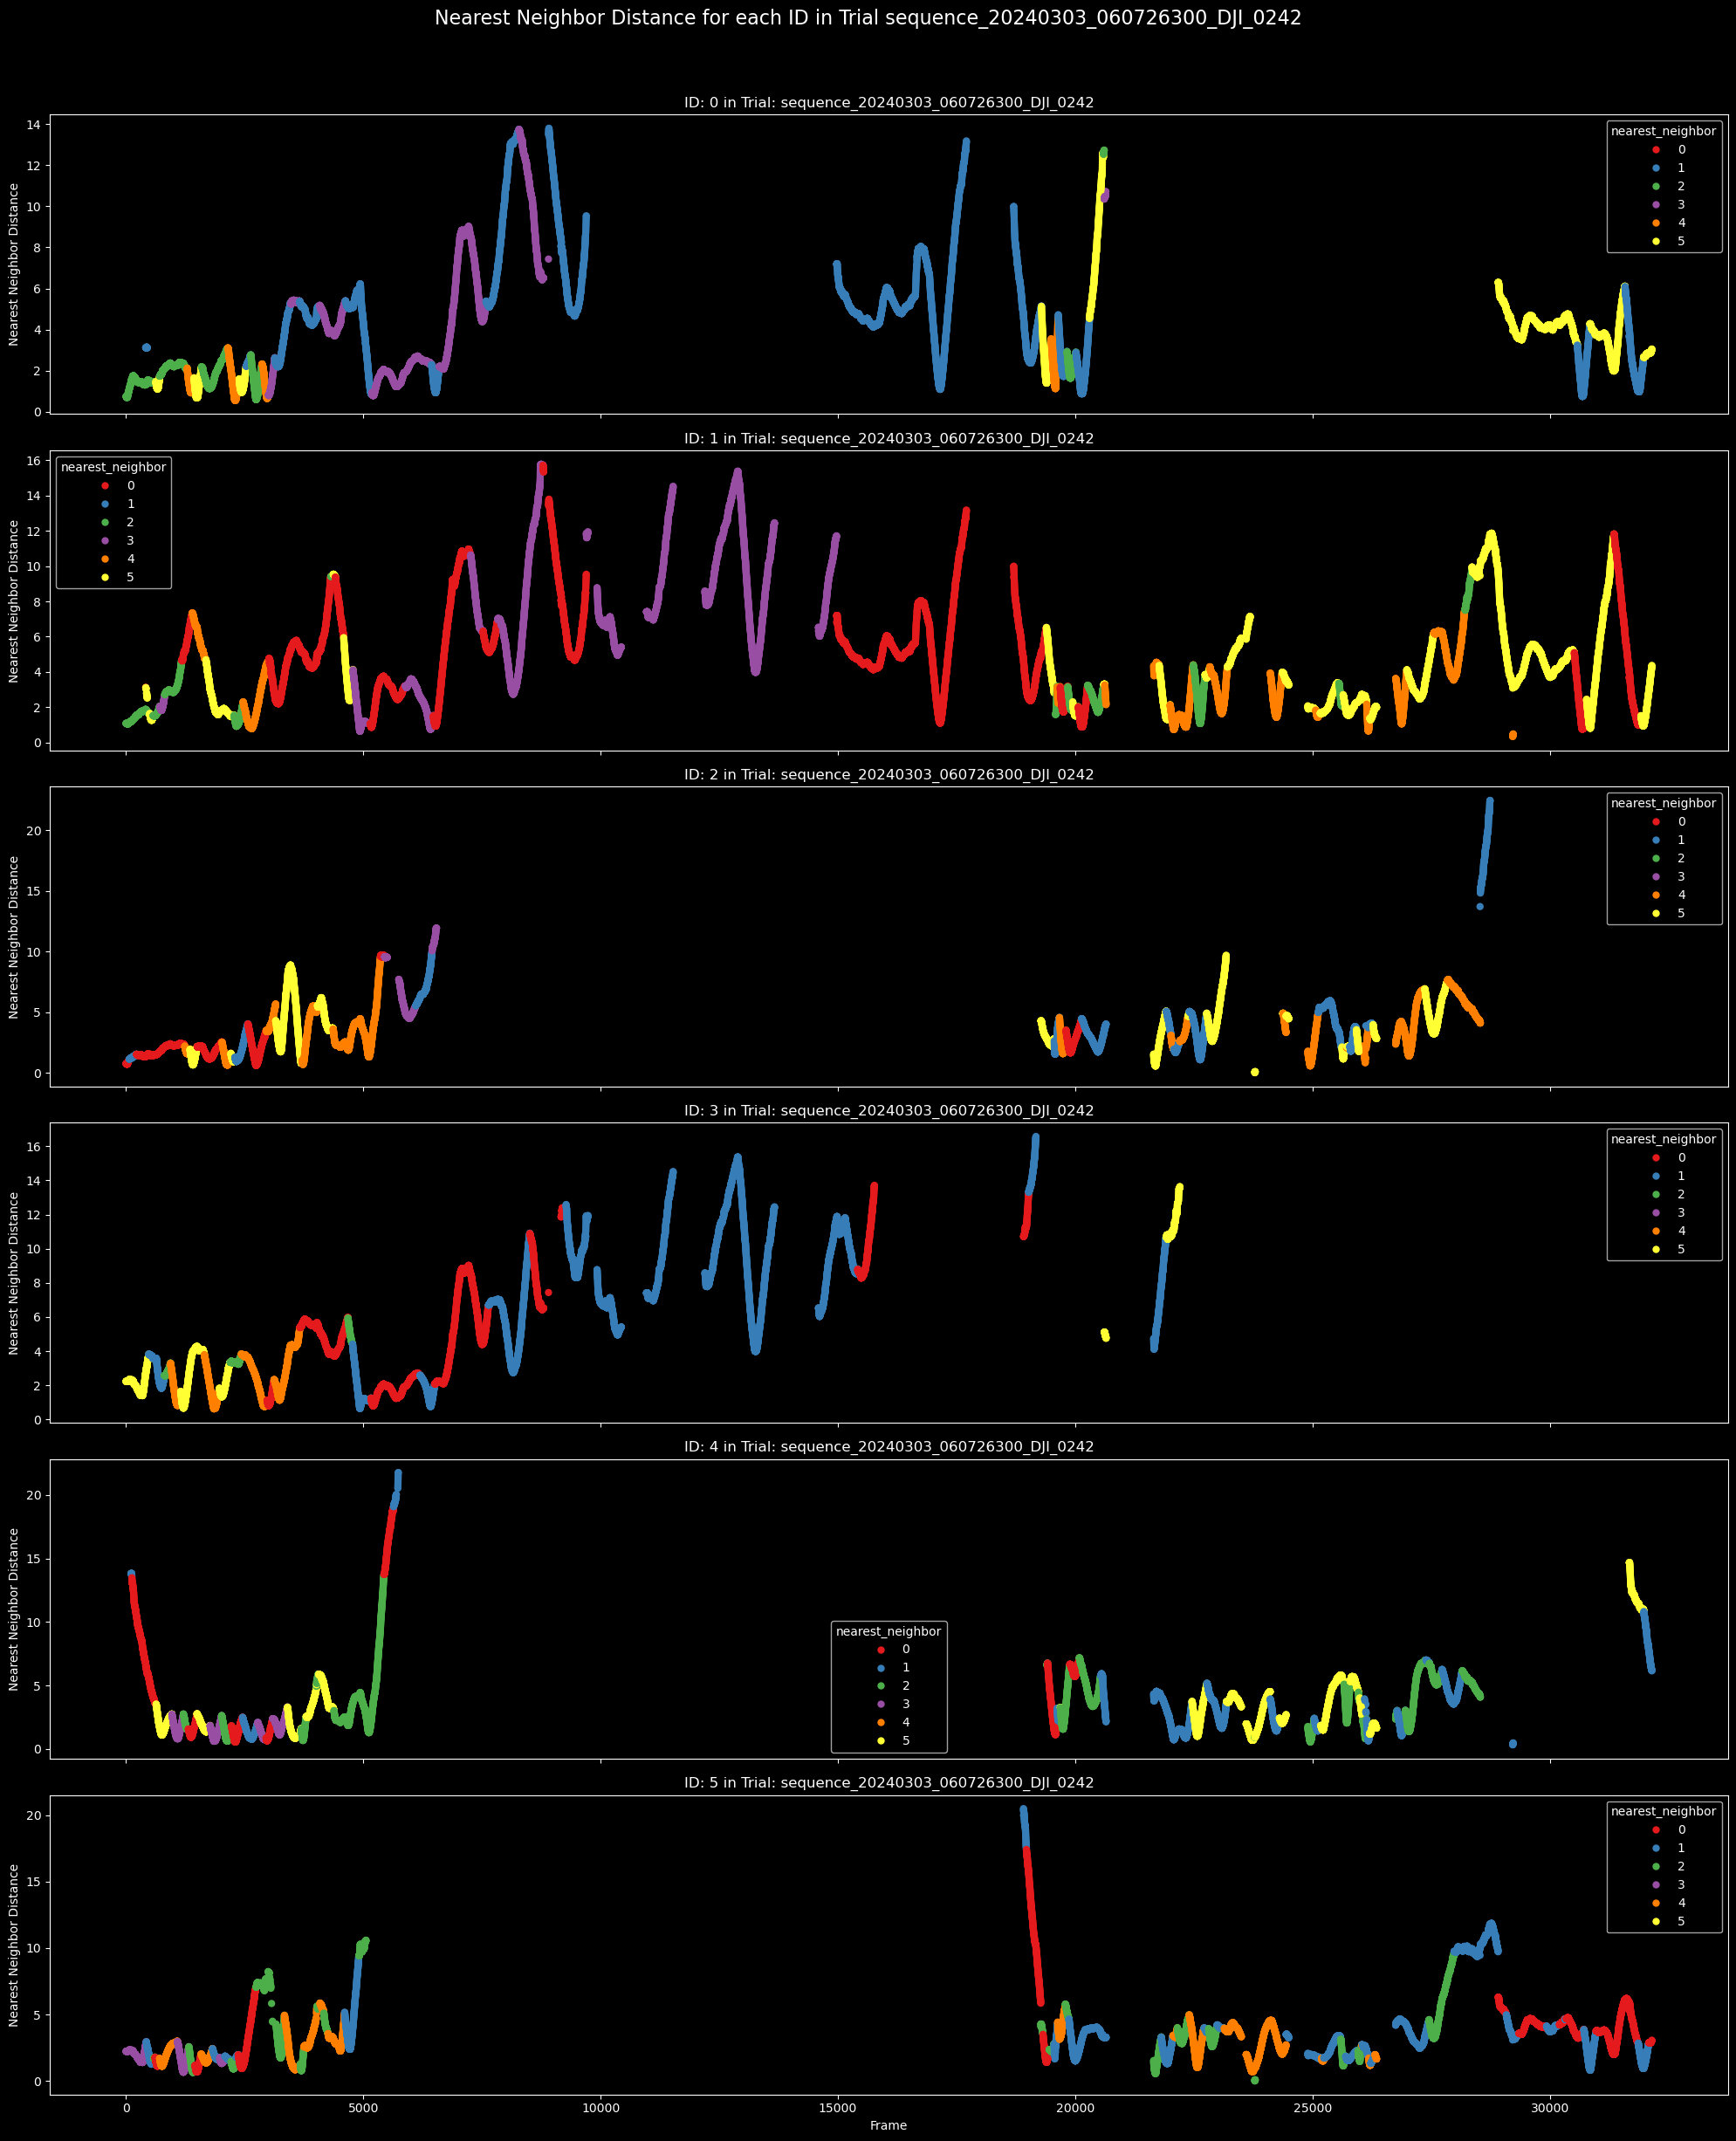

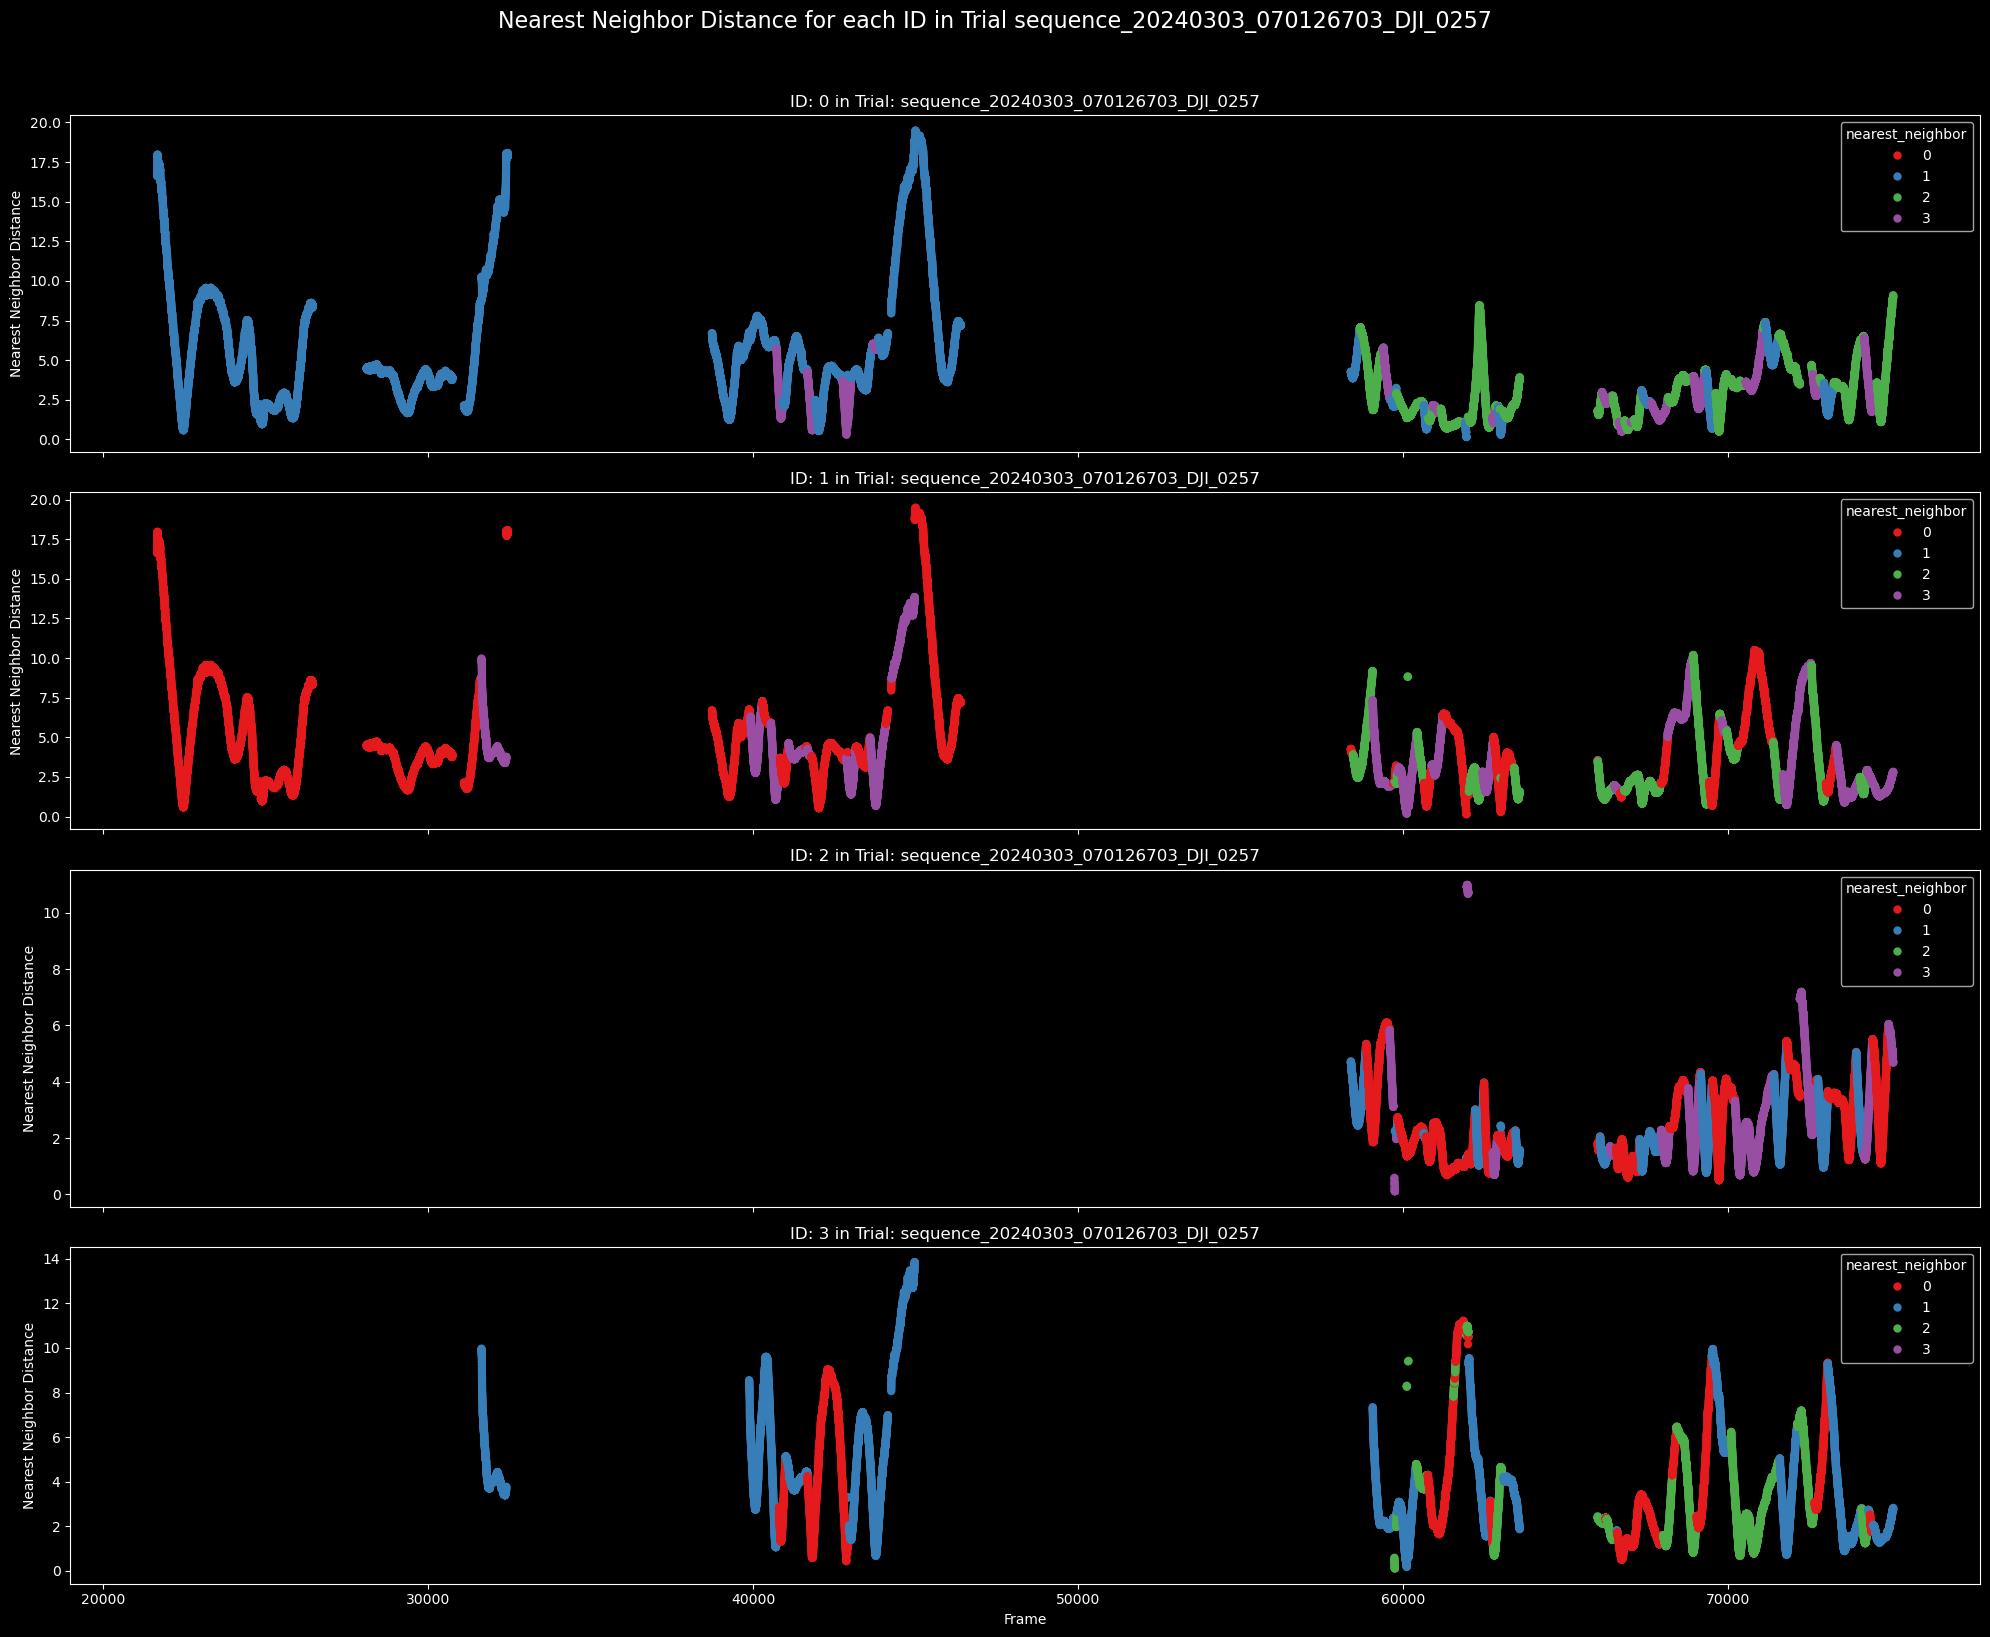

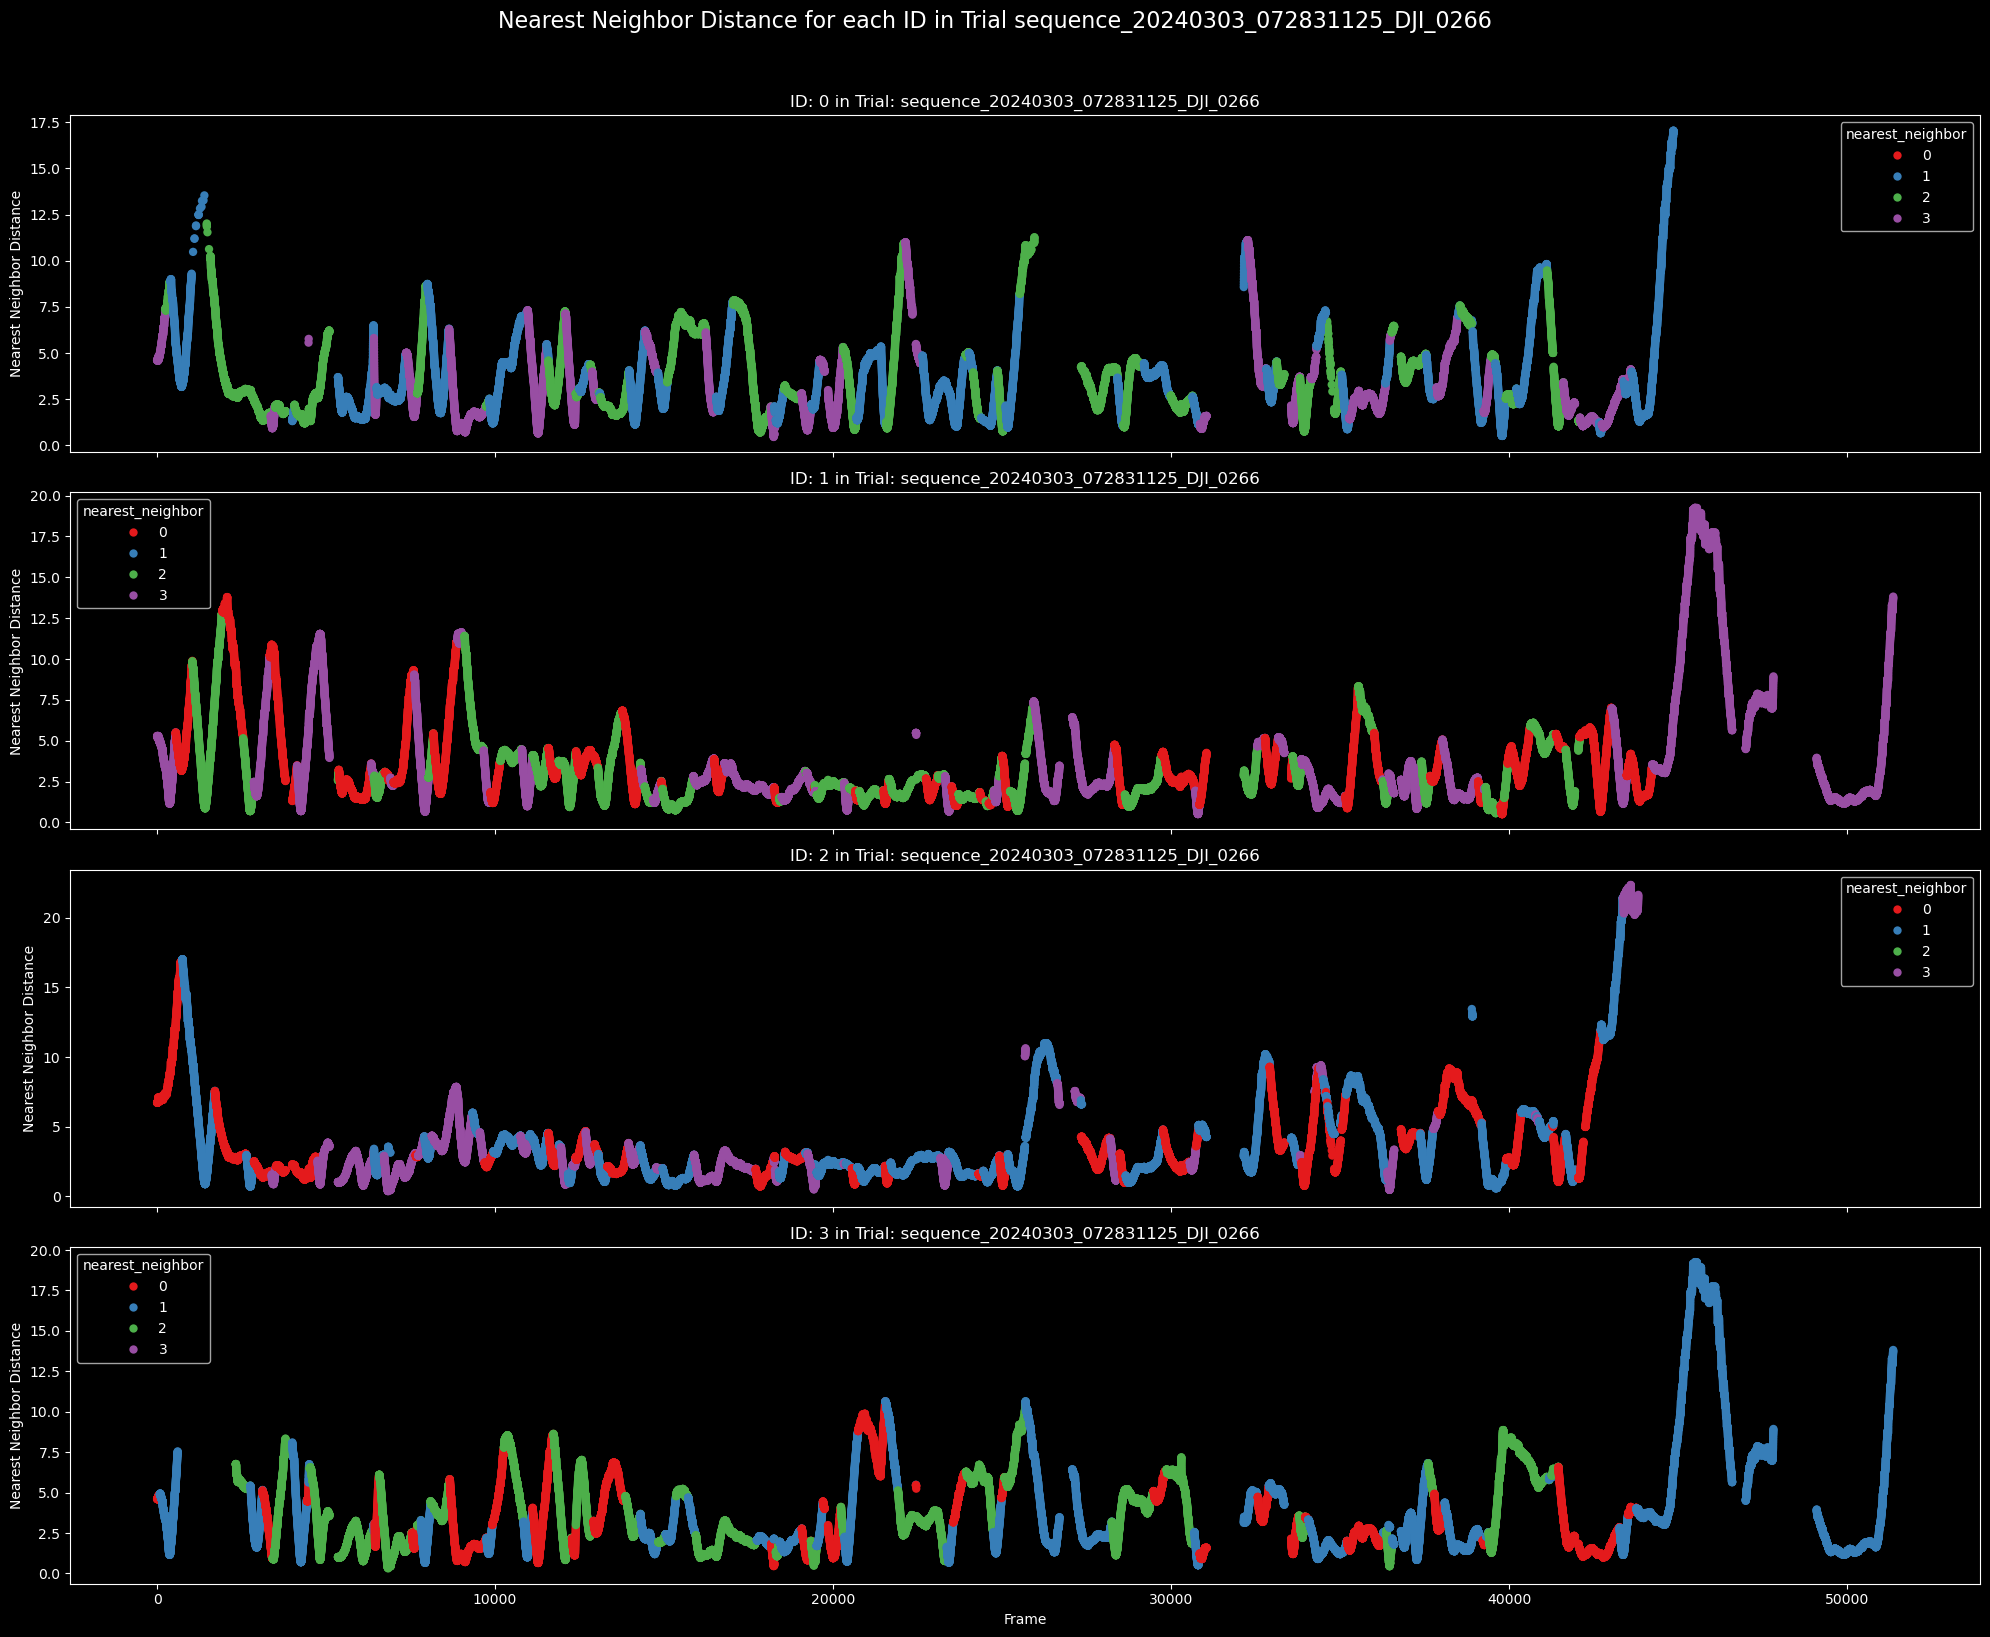

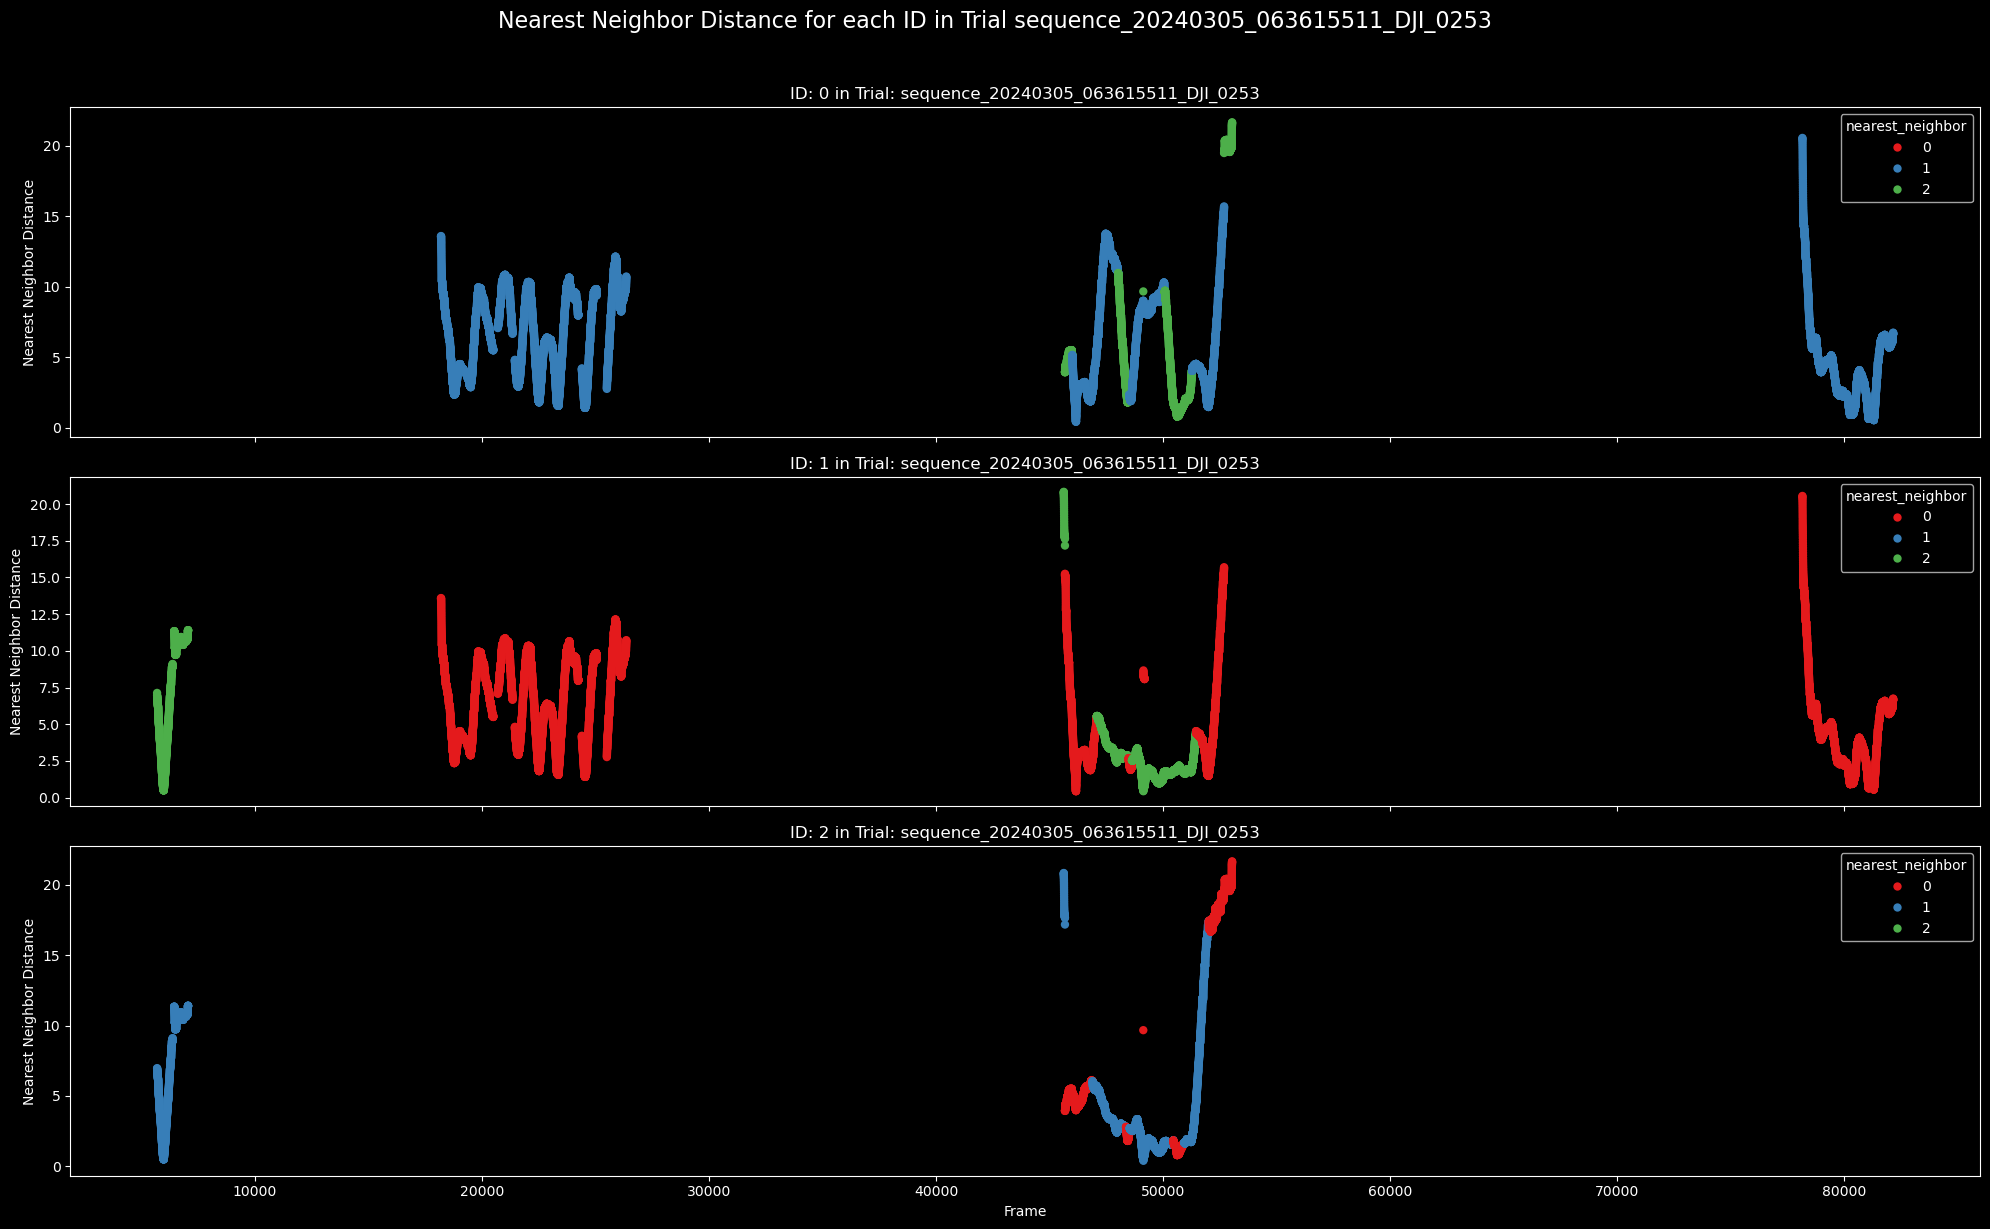

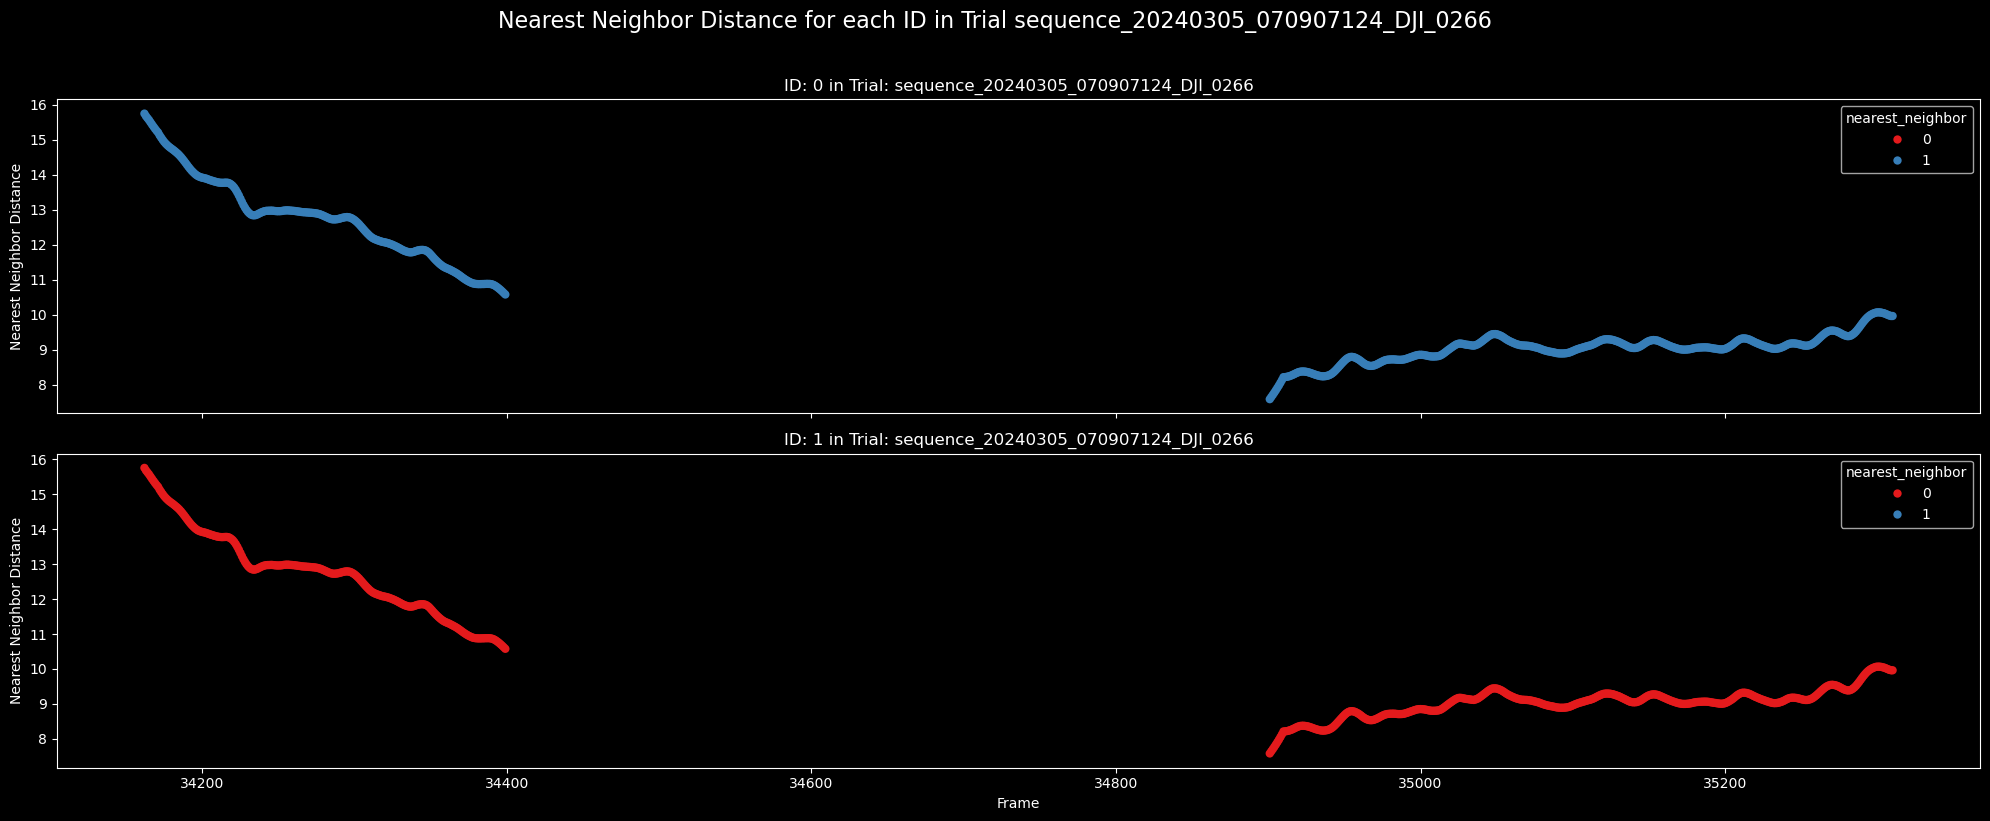

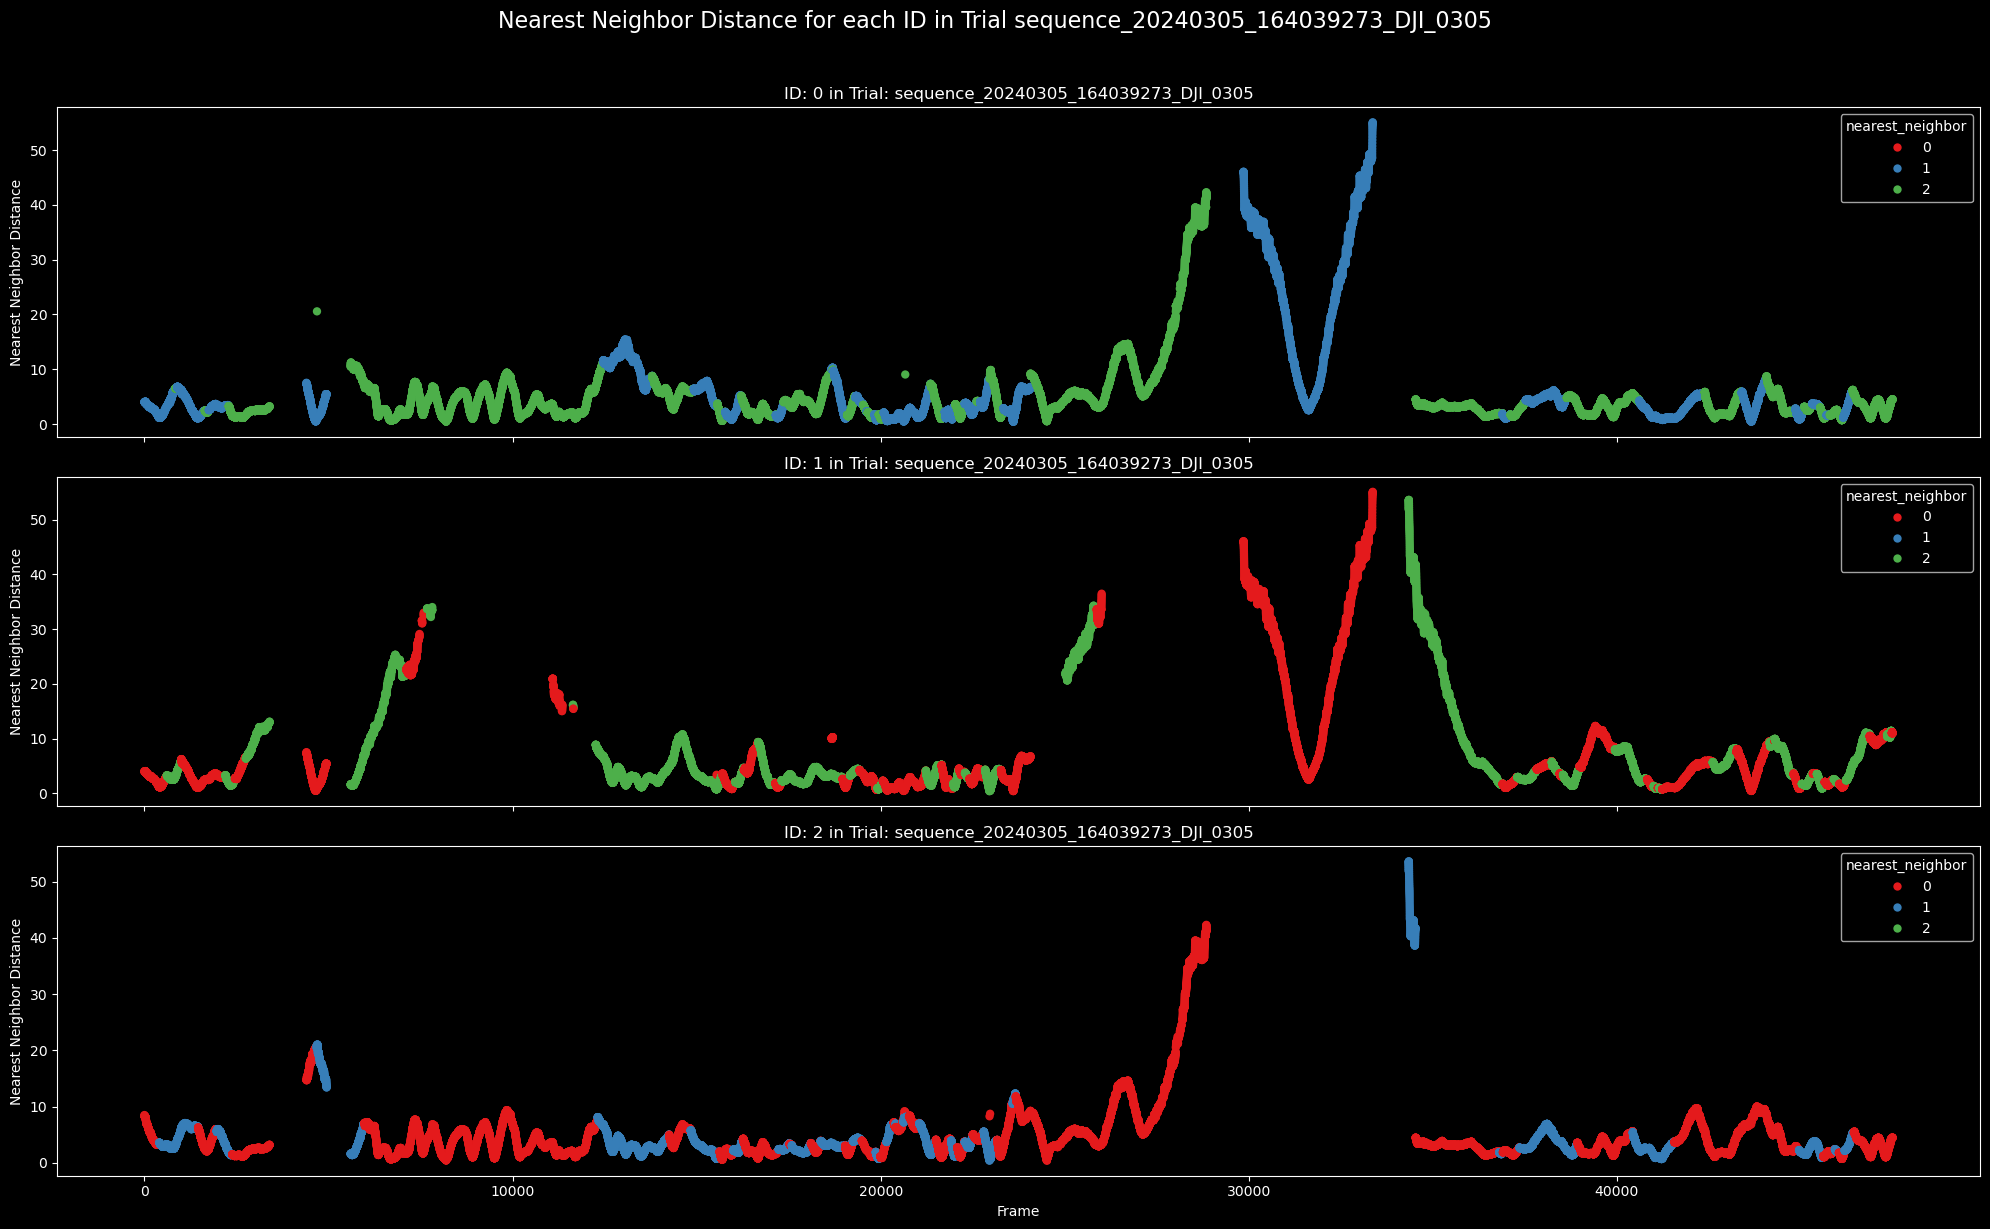

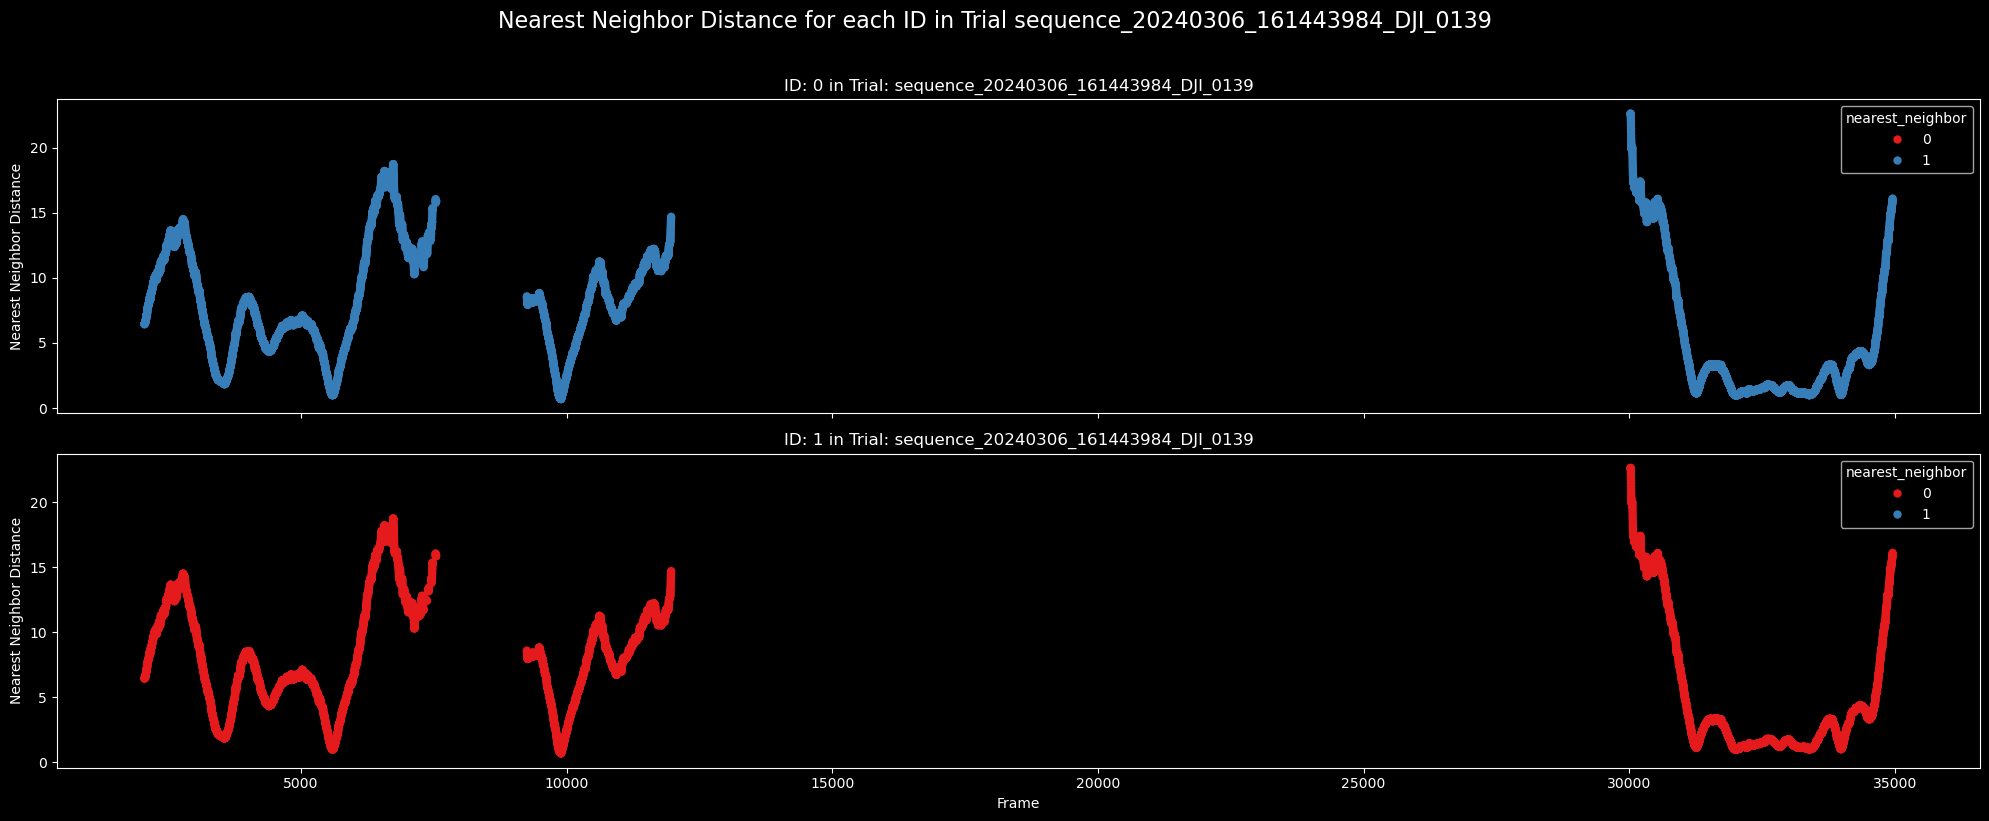

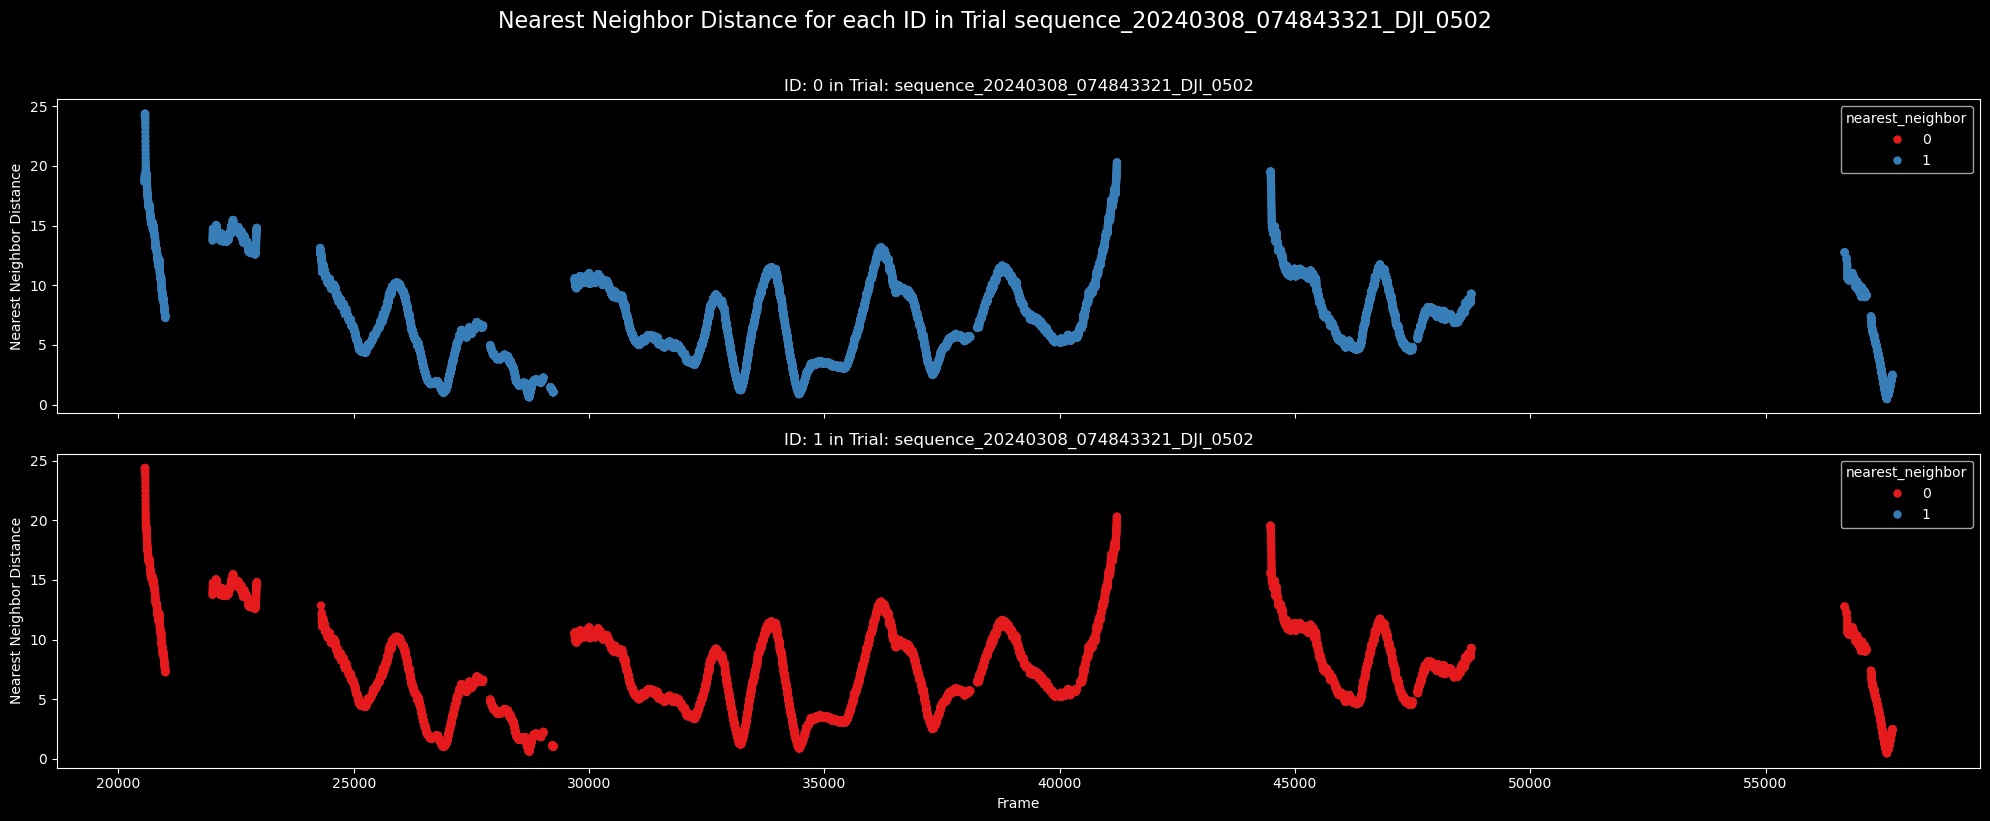

In [16]:
# Set up the color palette and color map
palette = sns.color_palette("Set1", n_colors=6)  
color_map = {i: palette[i] for i in range(len(palette))}

# Loop through each unique Trial and ID to create a plot for each
for trial in subset['Trial'].unique():
    trial_data = subset[subset['Trial'] == trial]  # Filter data for current trial
    unique_ids = trial_data['ID'].unique()  # Get all unique IDs in this trial

    # Create a subplot for each ID within this trial
    fig, axes = plt.subplots(len(unique_ids), 1, figsize=(20, 4 * len(unique_ids)), sharex=True)
    fig.suptitle(f"Nearest Neighbor Distance for each ID in Trial {trial}", y=1.02, fontsize=16)
    
    # If there’s only one ID, ensure axes are in list form to avoid errors
    if len(unique_ids) == 1:
        axes = [axes]

    # Plot for each ID in this trial
    for idx, (ax, unique_id) in enumerate(zip(axes, unique_ids)):
        # Filter out rows where nearest_neighbor is -1
        filtered_data = trial_data[(trial_data['ID'] == unique_id) & (trial_data['nearest_neighbor'] != -1)]

        # Plot the filtered data
        sns.scatterplot(
            ax=ax,
            x='frame',
            y='normalized_nnd',
            data=filtered_data,
            linewidth=0,
            hue='nearest_neighbor',
            palette=color_map
        )
        ax.set_title(f"ID: {unique_id} in Trial: {trial}")
        ax.set_ylabel("Nearest Neighbor Distance")
        ax.set_xlabel("Frame")
    
    plt.tight_layout()
    plt.show()


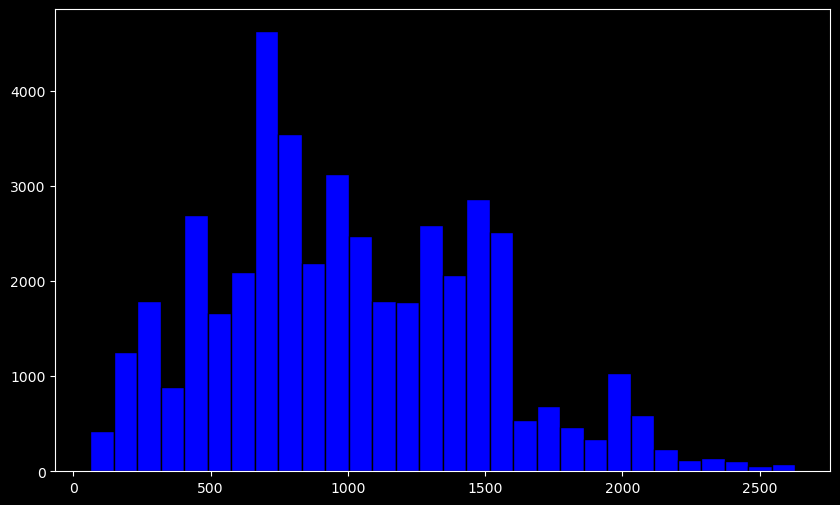

In [20]:
# Filter out any infinite or NaN values from mindist
filtered_mindist = mindist[np.isfinite(mindist)]

# Create a histogram for the filtered nearest neighbor distances
plt.figure(figsize=(10, 6))
plt.hist(filtered_mindist, bins=30, color='blue', edgecolor='black')
plt.show()


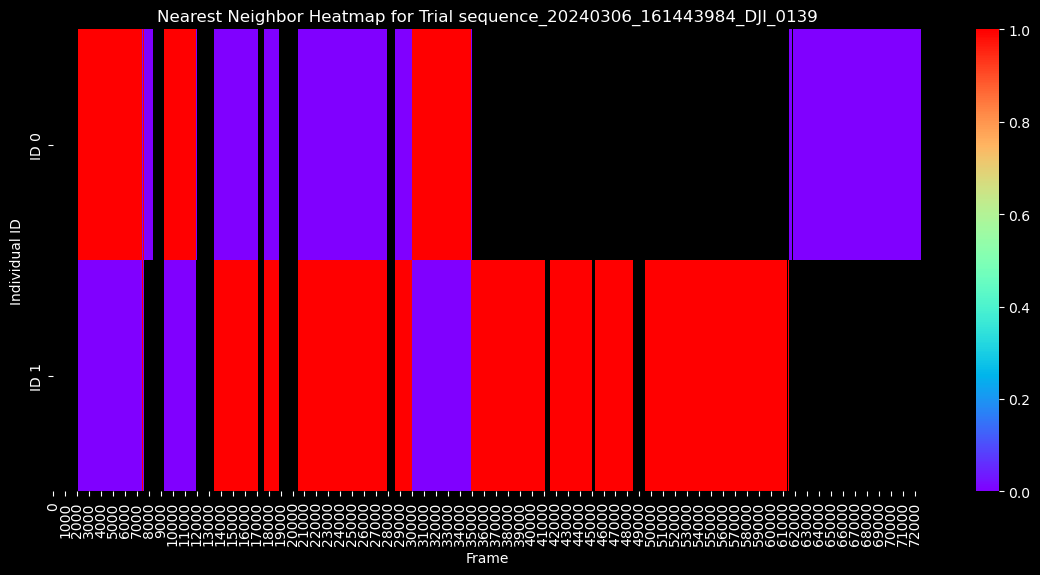

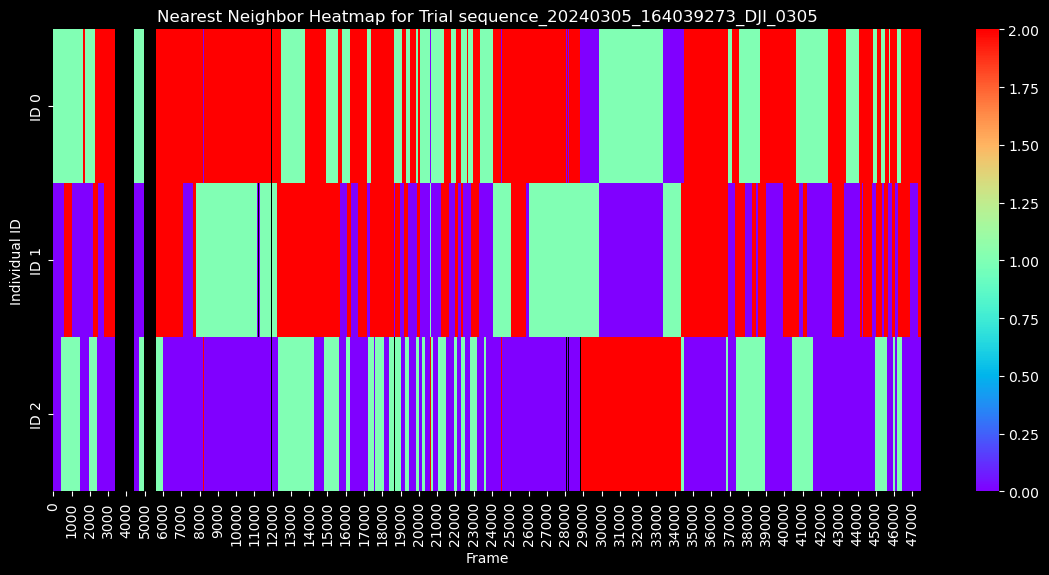

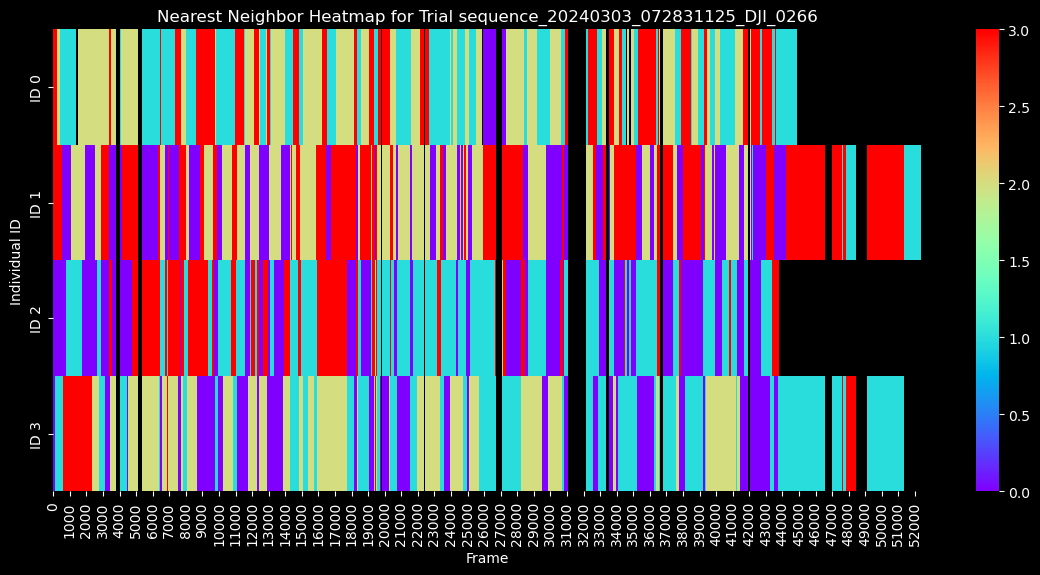

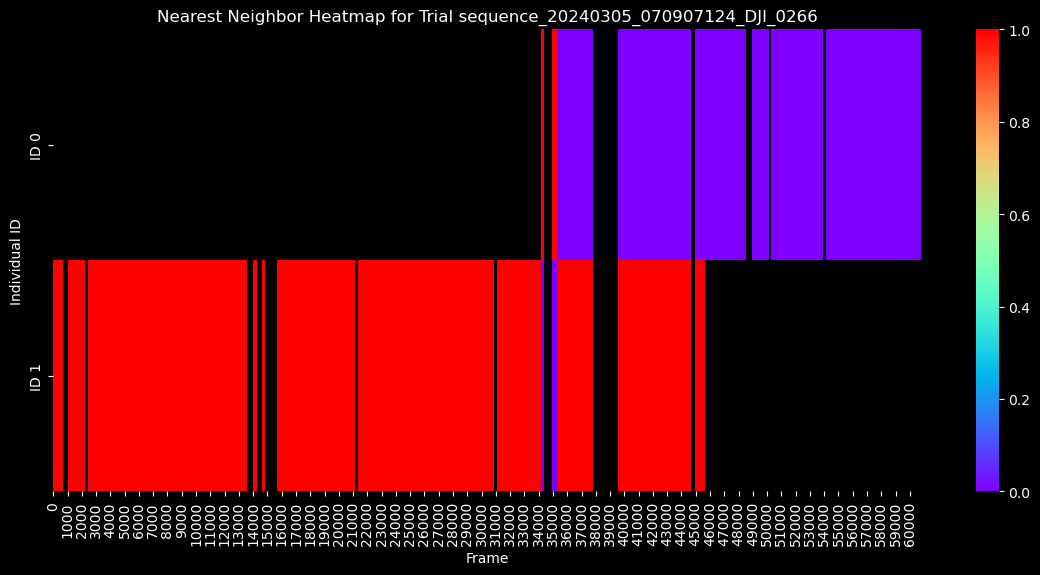

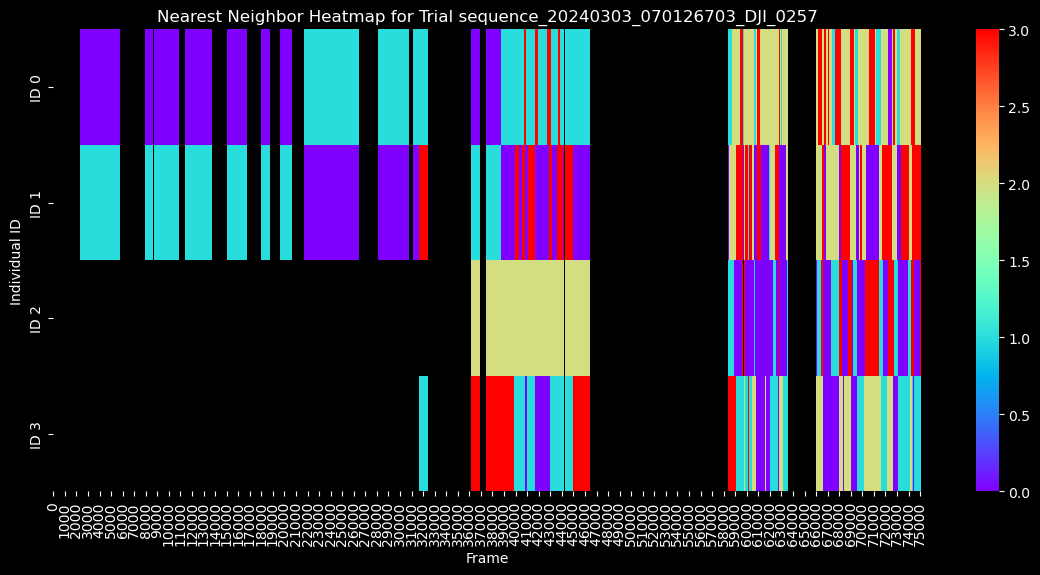

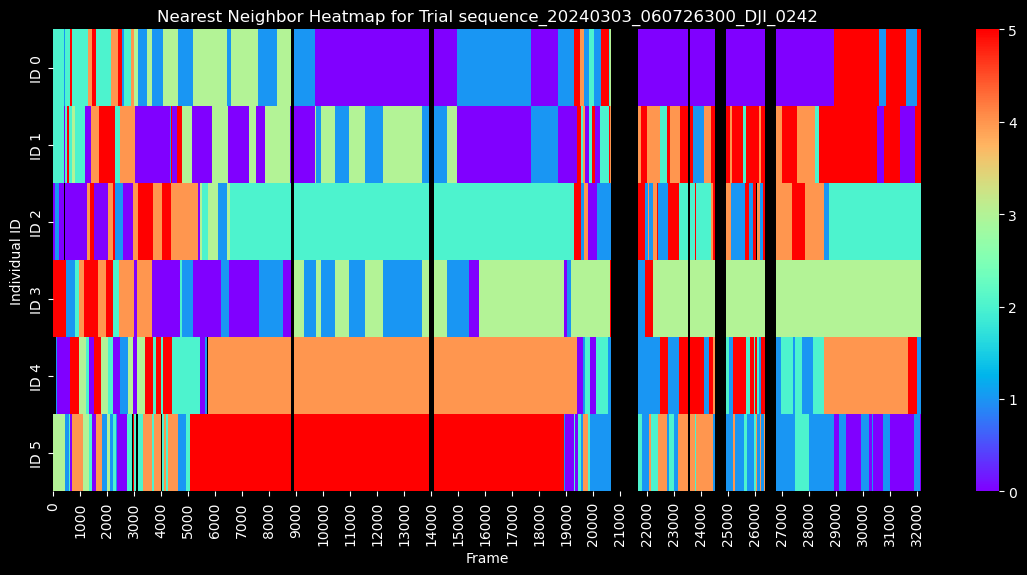

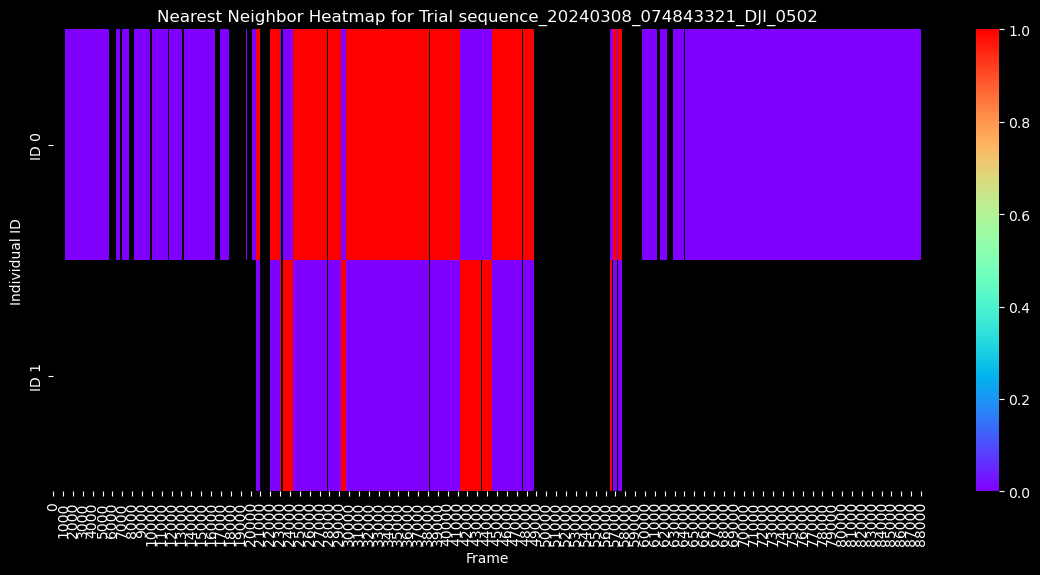

In [21]:
# Loop through each unique Trial and create a heatmap for each one
for trial in subset['Trial'].unique():
    # Filter data for the current trial
    trial_data = subset[subset['Trial'] == trial]
    
    # Get unique IDs and frames in the current trial
    unique_ids = trial_data['ID'].unique()
    maxframe = trial_data['frame'].max() + 1  # Assuming frame indexing starts from 0
    
    # Initialize a matrix for nearest neighbors with NaN to handle missing values
    heatmap_data = np.full((len(unique_ids), maxframe), np.nan)

    # Map each ID to a row index in the heatmap matrix
    id_to_index = {id_val: idx for idx, id_val in enumerate(unique_ids)}

    # Populate the heatmap matrix with nearest neighbor IDs
    for _, row in trial_data.iterrows():
        row_idx = id_to_index[row['ID']]
        frame_idx = int(row['frame'])
        heatmap_data[row_idx, frame_idx] = row['nearest_neighbor']
    
    # Plot the heatmap for the current trial
    plt.figure(figsize=(14, 6))
    sns.heatmap(heatmap_data, cmap='rainbow', cbar=True, 
                xticklabels=1000,  # Adjust label frequency for clarity if needed
                yticklabels=[f'ID {id_val}' for id_val in unique_ids])
    plt.title(f"Nearest Neighbor Heatmap for Trial {trial}")
    plt.xlabel("Frame")
    plt.ylabel("Individual ID")
    plt.show()


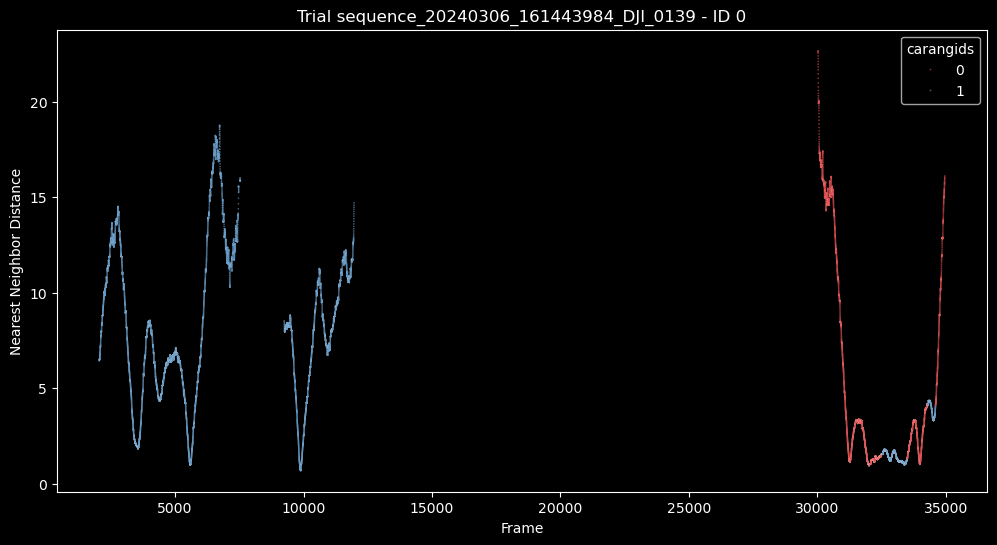

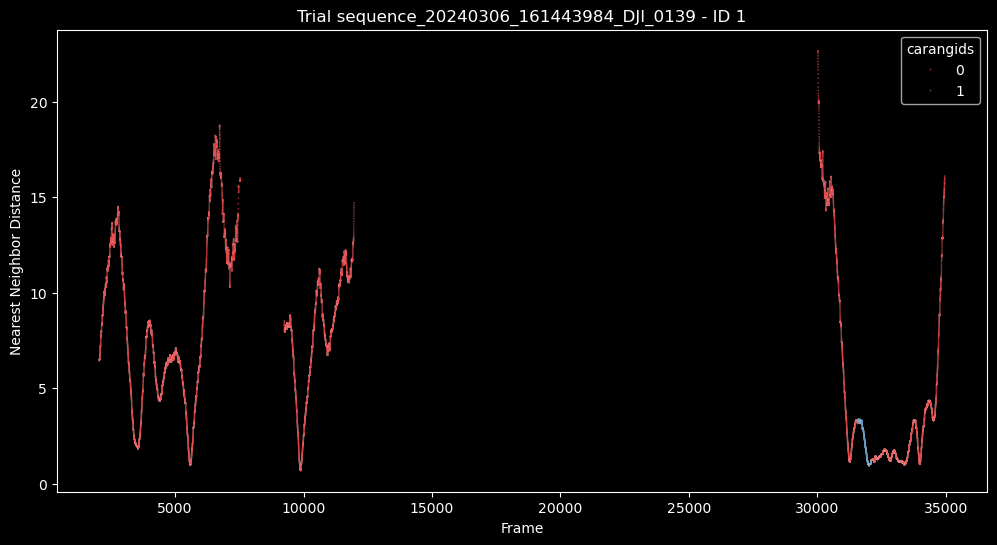

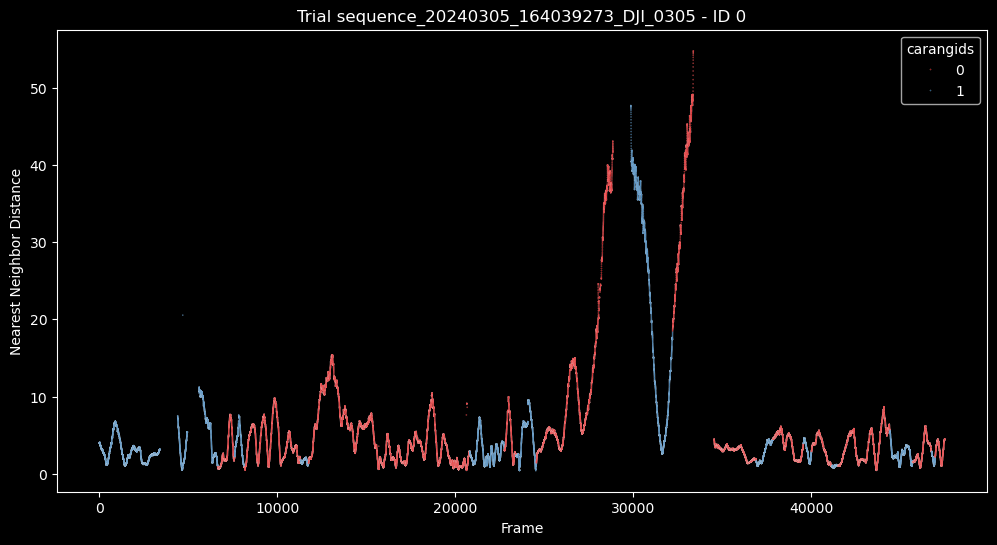

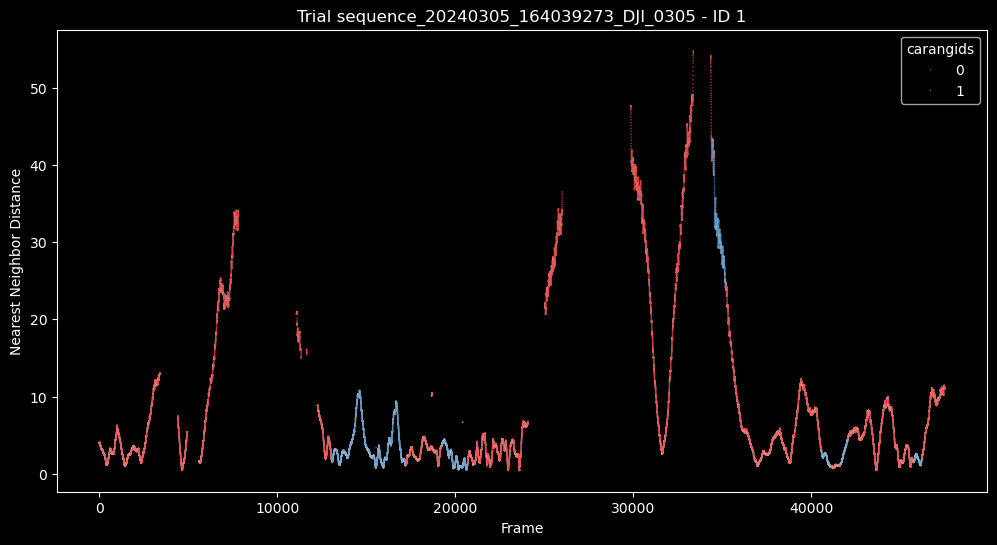

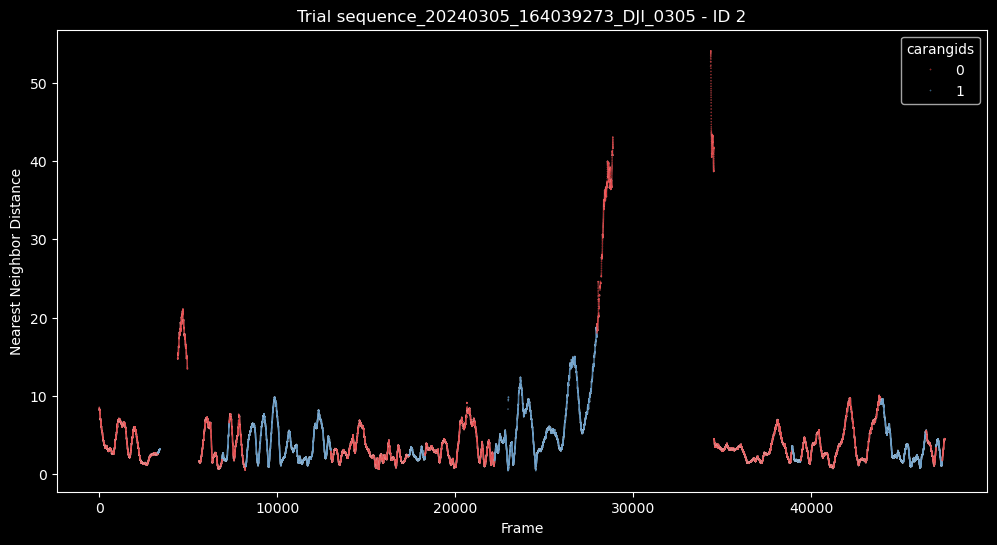

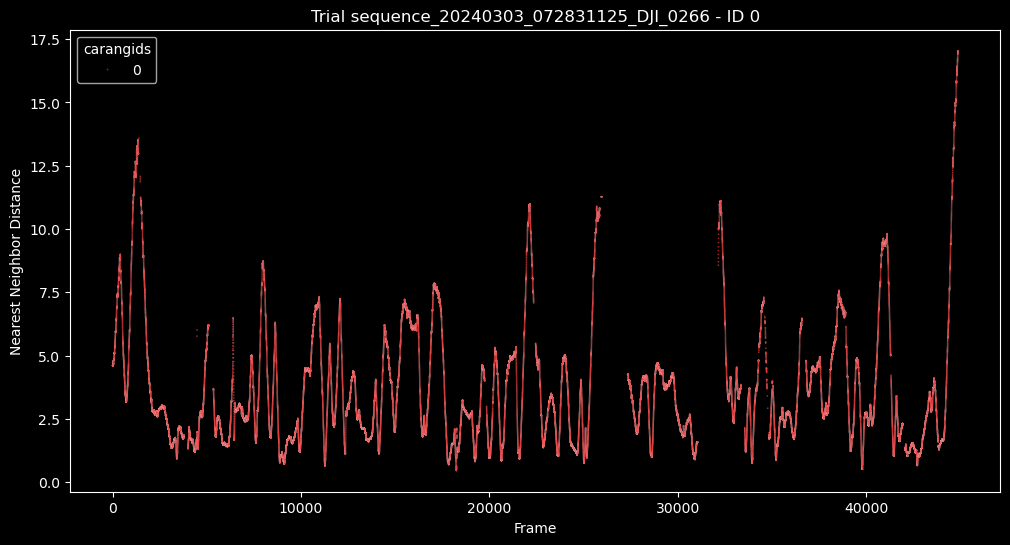

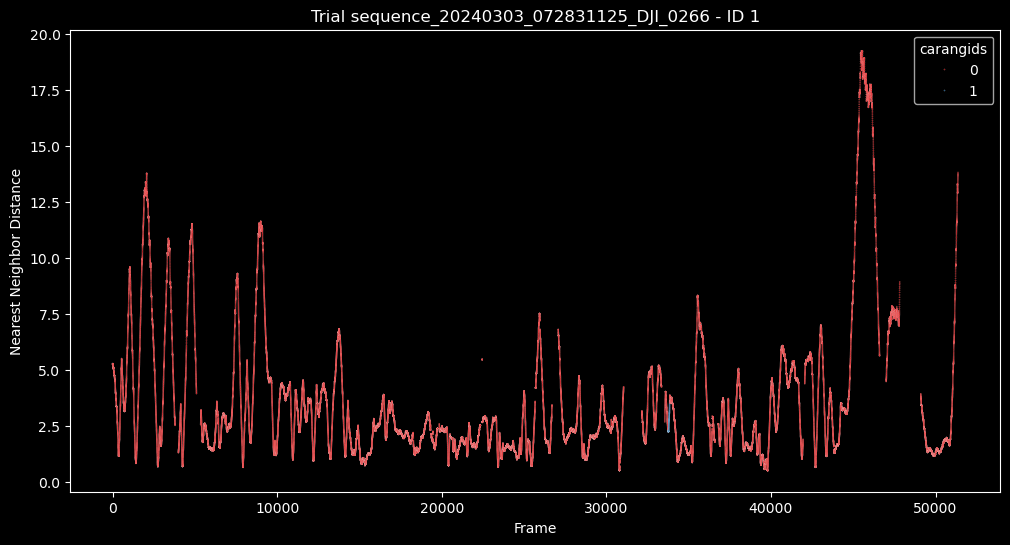

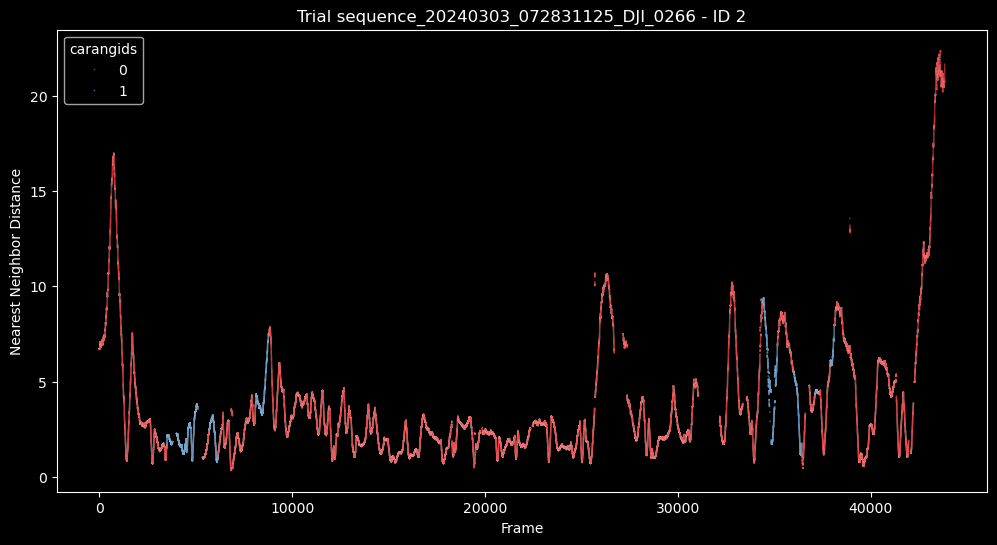

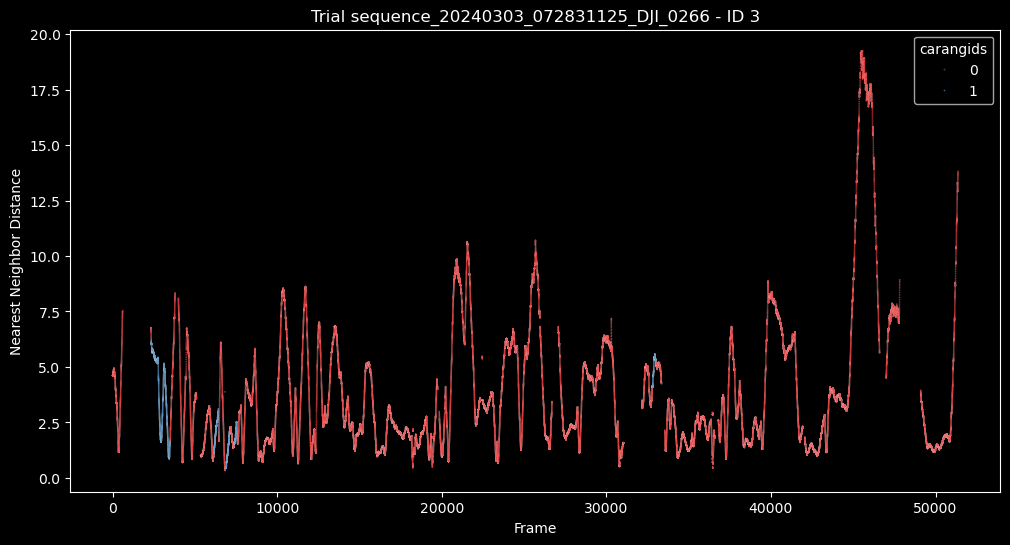

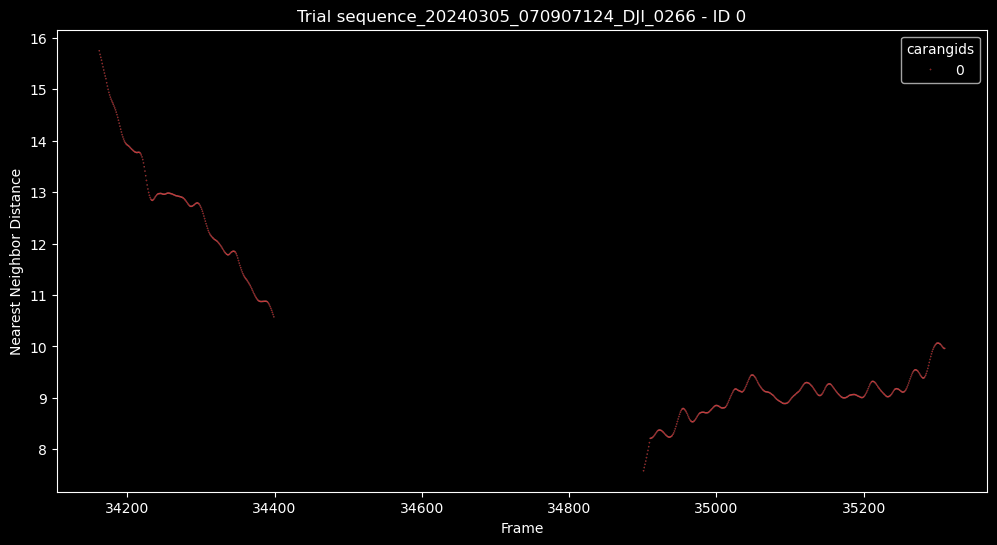

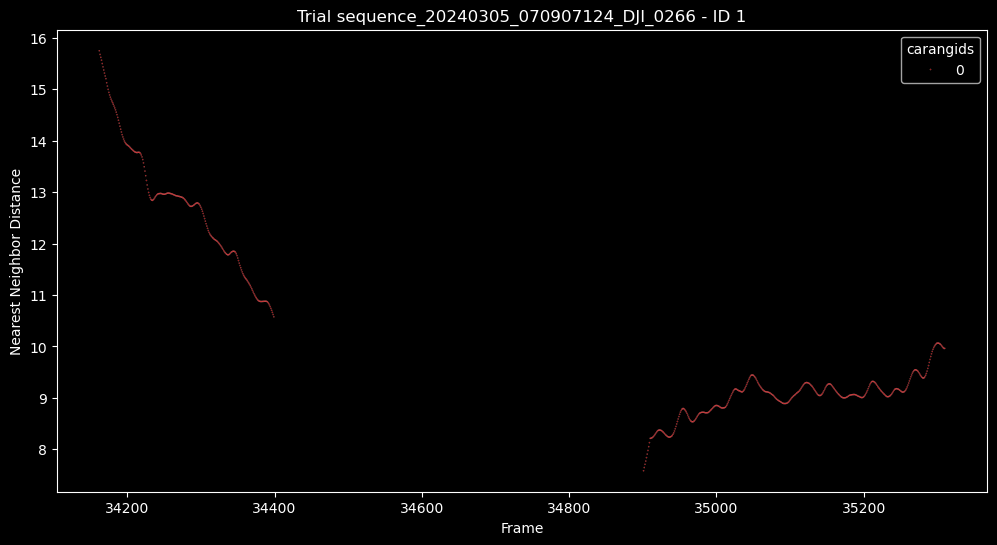

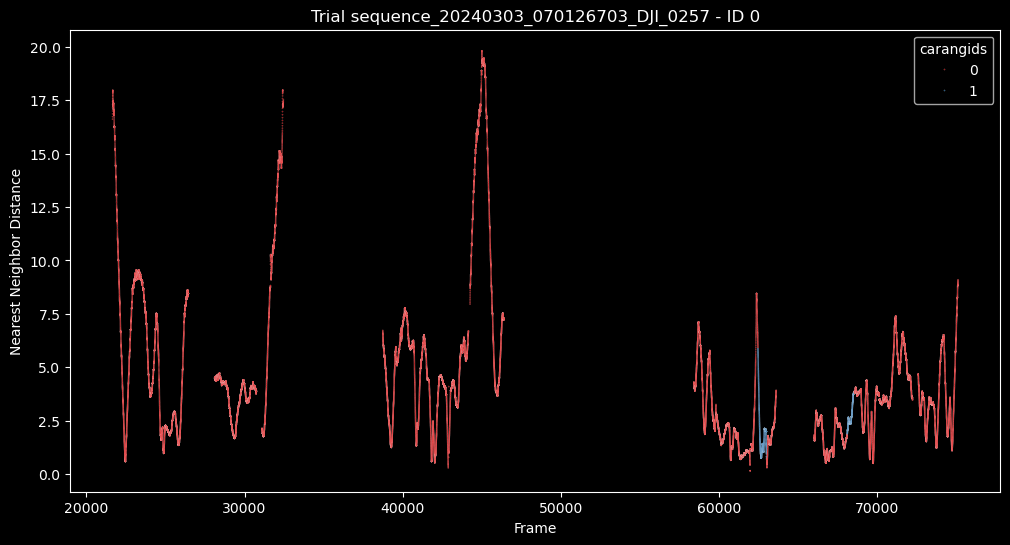

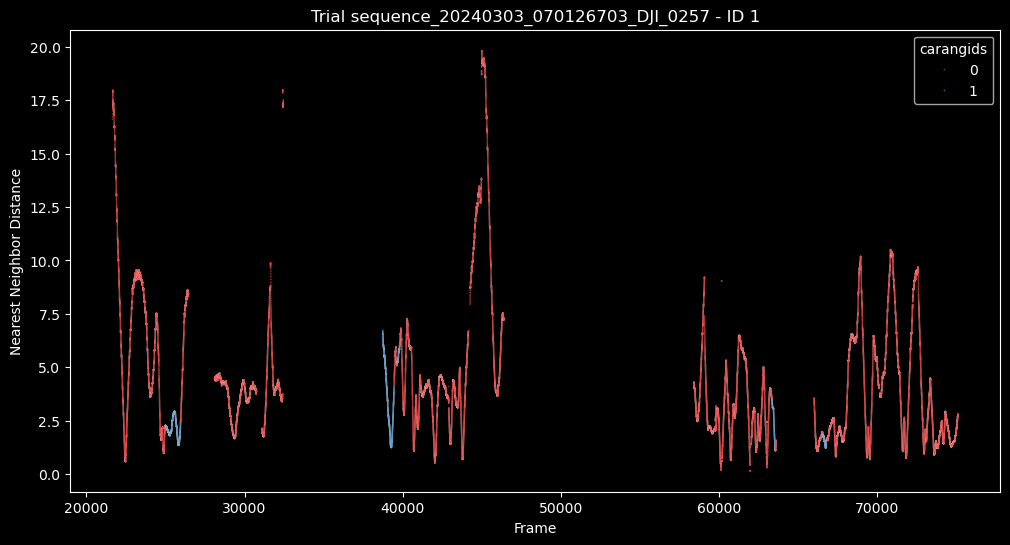

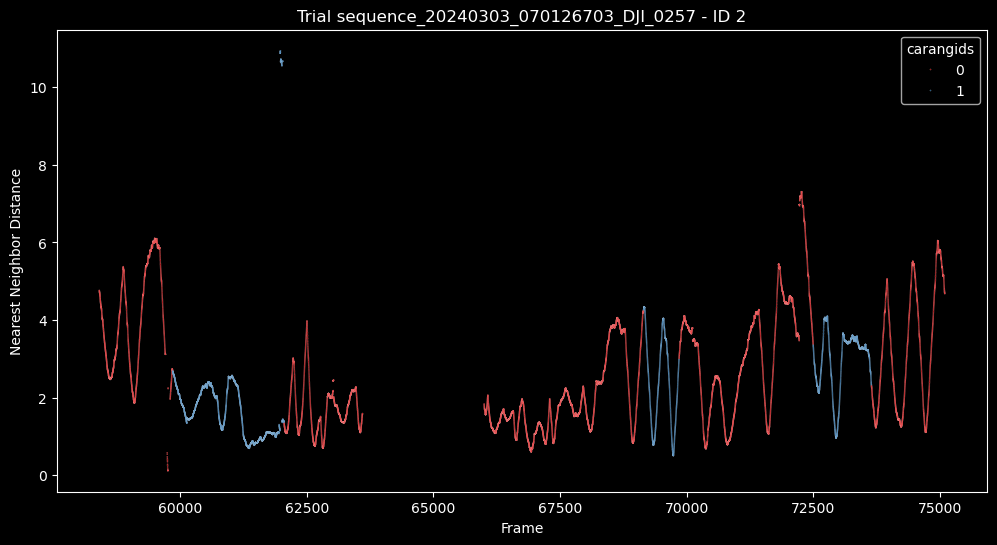

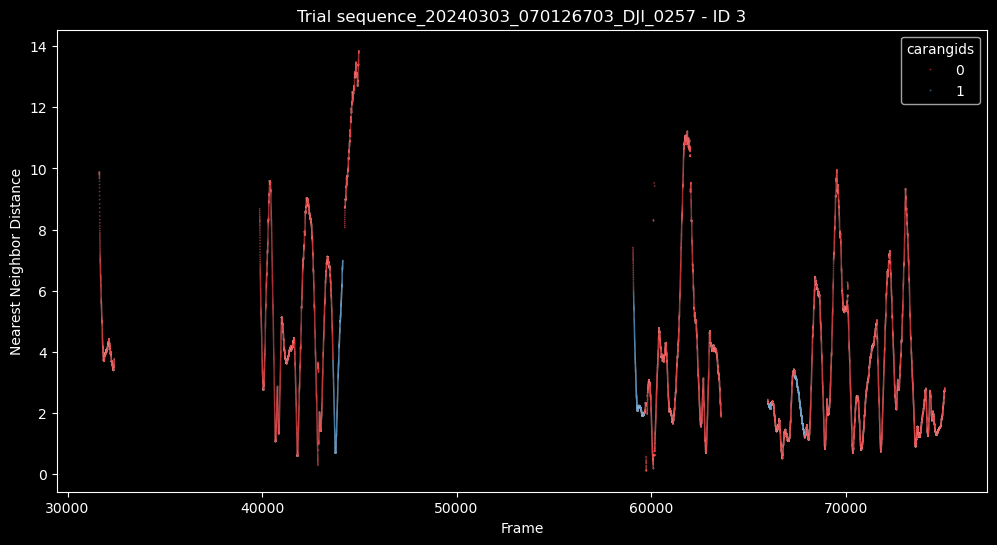

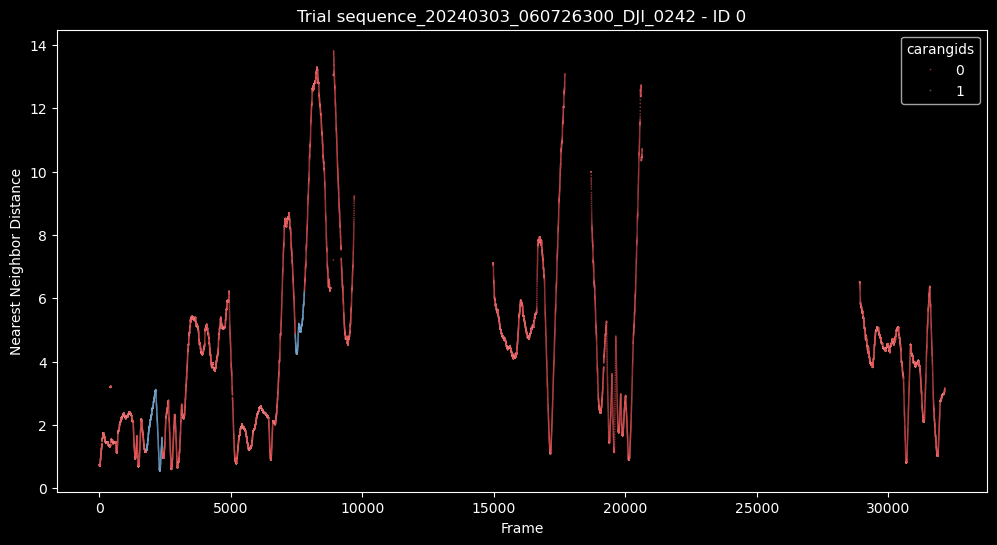

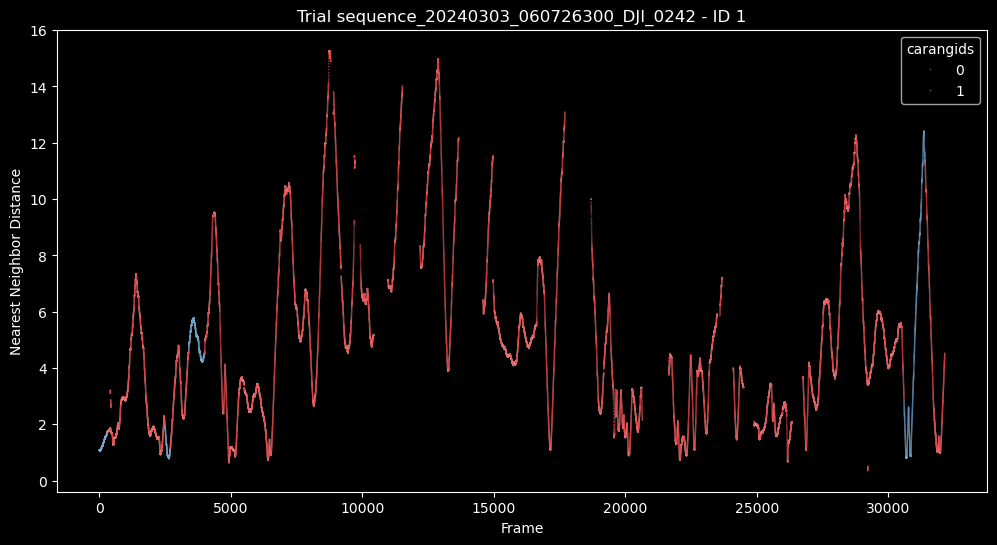

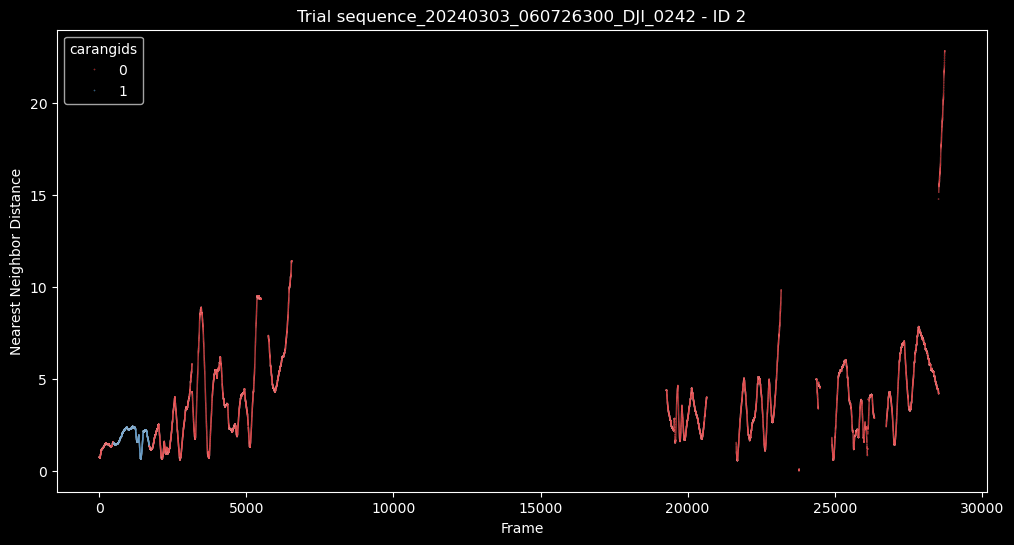

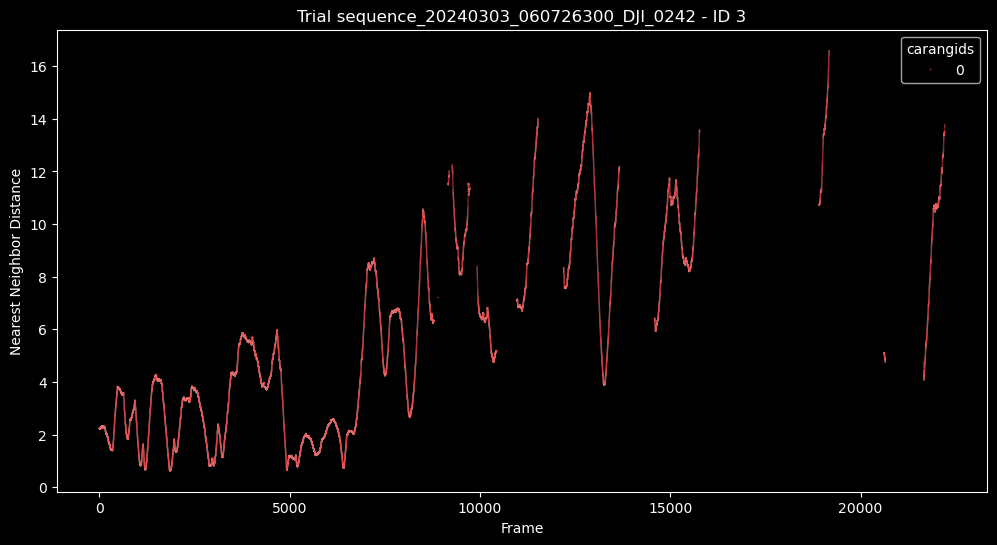

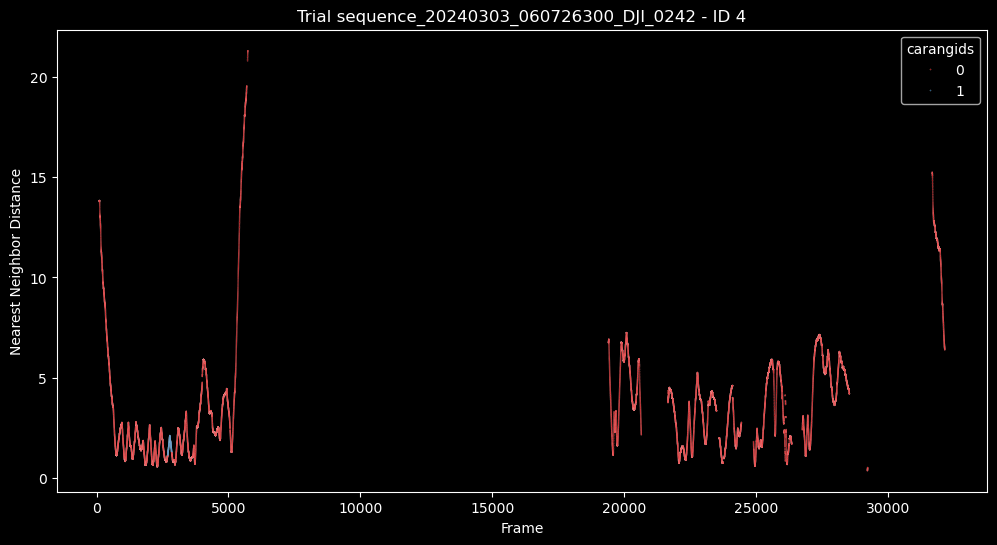

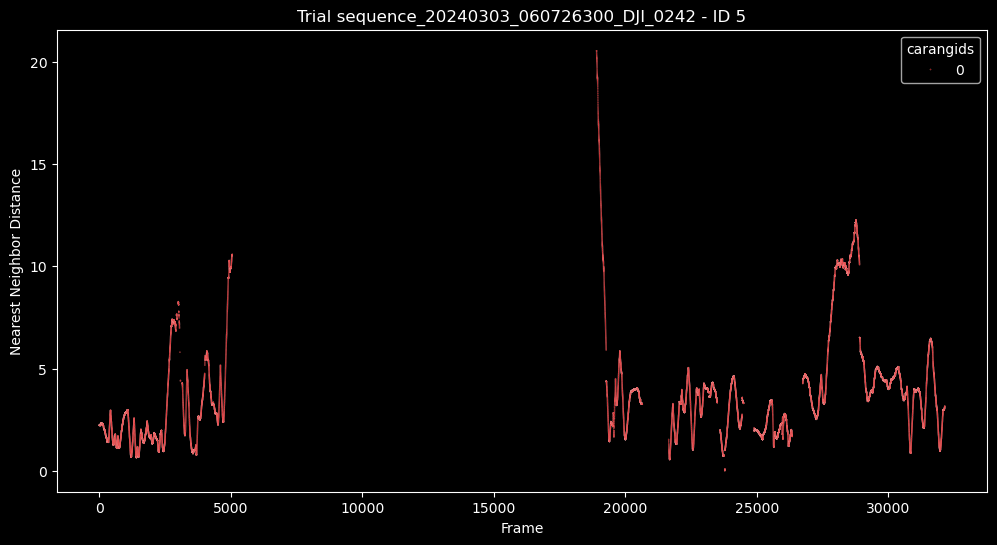

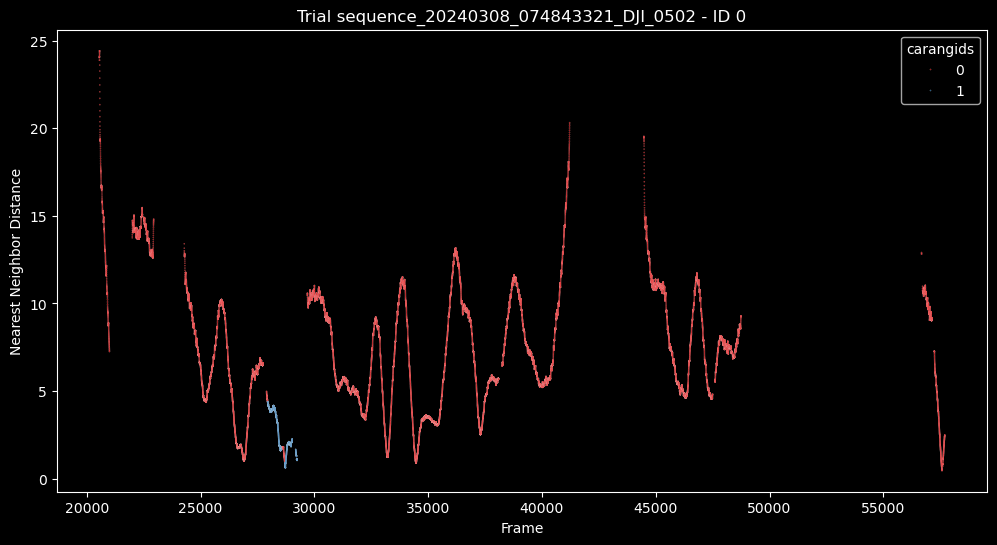

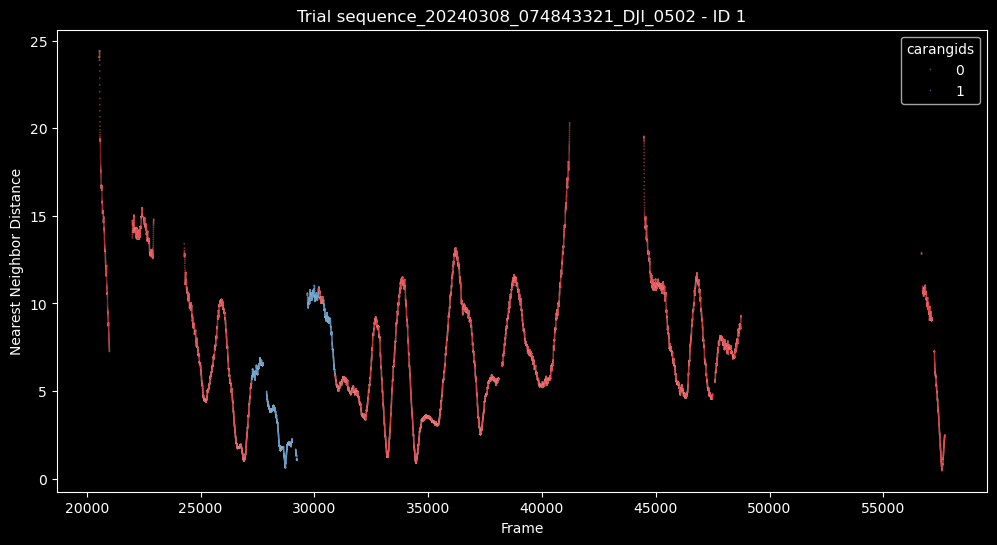

In [22]:
# Loop through each unique Trial
for trial in subset['Trial'].unique():
    trial_data = subset[subset['Trial'] == trial]  # Filter data for the current trial
    
    # Loop through each unique ID in the current trial
    for i in trial_data['ID'].unique():
        plt.figure(figsize=(12, 6))  # Create a new figure for each plot
        
        # Filter the data for the current ID and Trial
        fish_data = trial_data[trial_data['ID'] == i]
        
        # Create the scatter plot with hue based on the 'carangids' column
        sns.scatterplot(x='frame', y='normalized_nnd', data=fish_data, hue='carangids', palette="Set1", s=1, alpha=0.7)
        
        # Set the title and labels
        plt.title(f"Trial {trial} - ID {i}")
        plt.xlabel('Frame')
        plt.ylabel('Nearest Neighbor Distance')
        
        # Show the plot
        plt.show()


In [14]:
subset.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0   2051        82.087409   0   606.844014  -396.939687 -0.435146   2051   
1   2052        76.964699   0   608.723694  -396.273295 -0.456252   2052   
2   2053        75.903308   0   610.451965  -395.569743 -0.479337   2053   
3   2054        71.775297   0   612.184855  -394.984894 -0.500498   2054   
4   2055        81.043147   0   613.870341  -394.378459 -0.521608   2055   

    time        headx        heady  ...   midpoint_y  carangids  \
0  40.91  3172.583333  1069.333333  ...  1082.916667          1   
1  40.93  3174.333333  1068.916667  ...  1083.125000          1   
2  40.95  3175.916667  1068.416667  ...  1083.250000          1   
3  40.97  3177.416667  1067.916667  ...  1083.333333          1   
4  40.99  3178.833333  1067.500000  ...  1083.416667          1   

   drone_movement  ID_checked  smoothed_body_length  standardized_speed  \
0               0         1.0            109.851996            0.747255   
1               0         1.0            110.187803            0.698487   
2               0         1.0            110.539454            0.686663   
3               0         1.0            110.882277            0.647311   
4               0         1.0            111.196668            0.728827   

   nearest_neighbor  nn_distance  mean_body_length  normalized_nnd  
0                 1   696.033544        108.149438        6.435850  
1                 1   698.254526        108.313050        6.446633  
2                 1   700.389238        108.468860        6.457054  
3                 1   702.533543        108.648260        6.466128  
4                 1   704.553259        108.808531        6.475166  

[5 rows x 41 columns]

C:\Users\sophi\AppData\Local\Temp\ipykernel_28924\3966609919.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Carangid", y=metric, data=avg_df, palette=palette)
C:\Users\sophi\AppData\Local\Temp\ipykernel_28924\3966609919.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


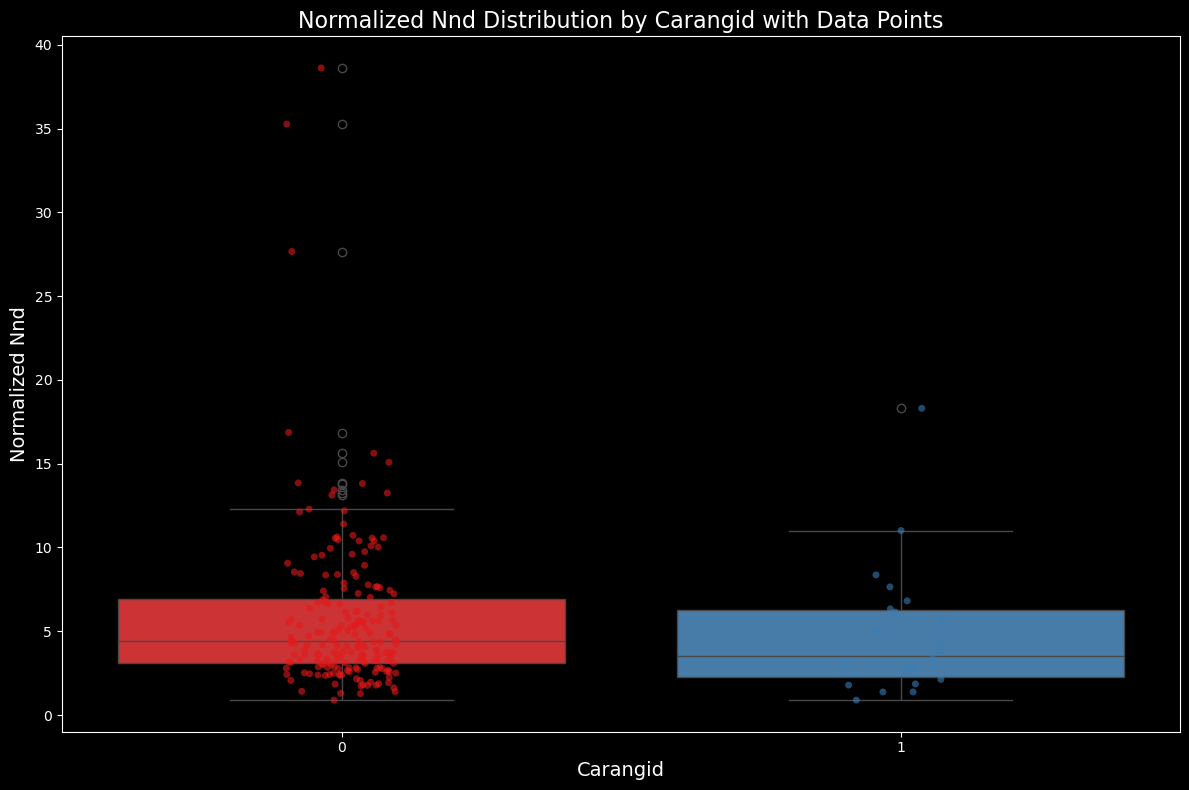

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Function to calculate averages for multiple metrics with filtering
def calculate_segment_averages(data, metrics, min_count=100):
    averages = []
    for trial, trial_data in data.groupby('Trial'):
        for id_, id_data in trial_data.groupby('ID'):
            for segment, segment_data in id_data.groupby('segment'):  # Group by 'segment'
                if len(segment_data) >= min_count:  # Filter by minimum count
                    avg_values = {metric: segment_data[metric].mean() for metric in metrics}
                    avg_values['Trial'] = trial  # Add Trial information
                    avg_values['Carangid'] = segment_data['carangids'].iloc[0]  # Add carangid info
                    averages.append(avg_values)  # Append average values for all metrics
    return pd.DataFrame(averages)

# Metrics to plot
metrics = ['normalized_nnd']

# Calculate the averages for the metrics
avg_df = calculate_segment_averages(subset, metrics)

# Ensure 'Carangid' is treated as a categorical variable
avg_df['Carangid'] = avg_df['Carangid'].astype('category')

# Define color palette for carangid (0: red, 1: blue) with string keys to match the data
palette="Set1"

# Create plots for each metric
for metric in metrics:
    plt.figure(figsize=(12, 8))

    # Box plot for the current metric, with x as 'Carangid' and the specified color palette
    sns.boxplot(x="Carangid", y=metric, data=avg_df, palette=palette)

    # Overlay strip plot for data points with the same color palette
    sns.stripplot(
        x="Carangid", y=metric, data=avg_df, palette=palette, marker="o", alpha=0.6, jitter=True
    )

    # Title and labels
    plt.title(f'{metric.replace("_", " ").title()} Distribution by Carangid with Data Points', fontsize=16)
    plt.xlabel("Carangid", fontsize=14)
    plt.ylabel(metric.replace("_", " ").title(), fontsize=14)

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()

C:\Users\sophi\AppData\Local\Temp\ipykernel_25164\2003754391.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Trial", y=metric, data=avg_df, palette=palette)
C:\Users\sophi\AppData\Local\Temp\ipykernel_25164\2003754391.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


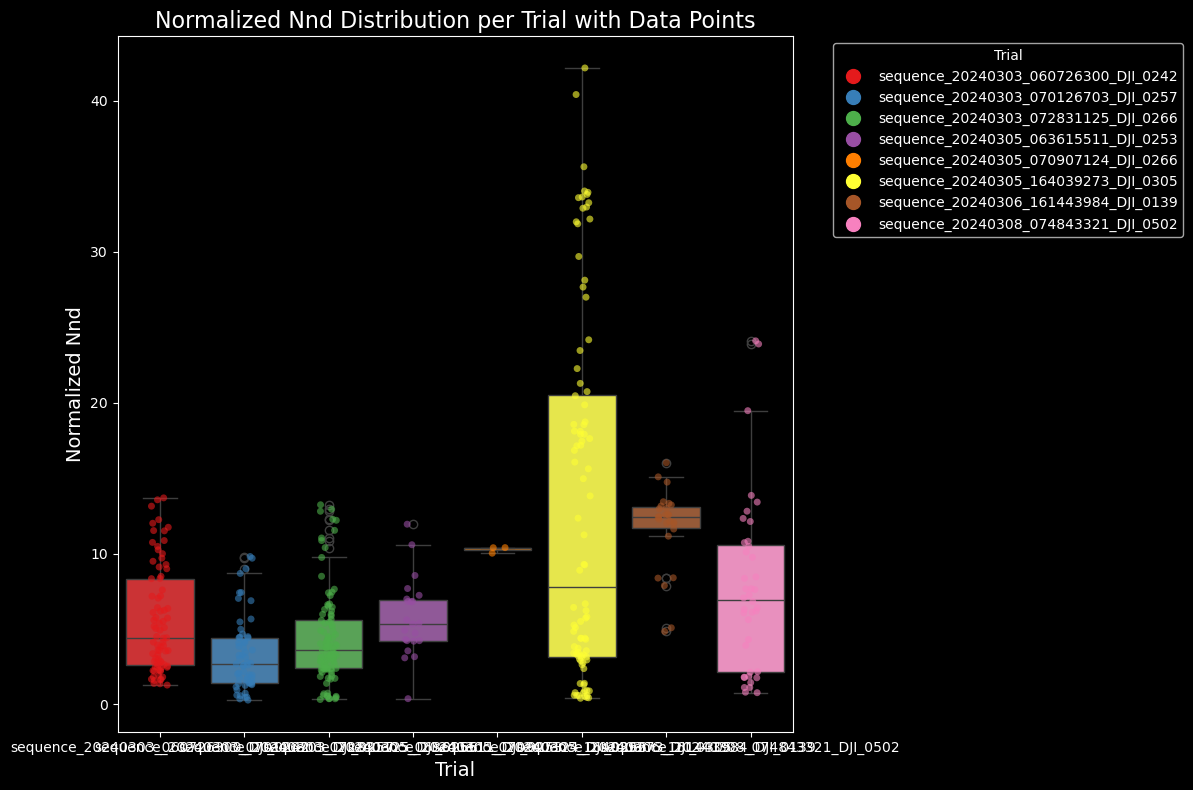

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Function to calculate averages for a metric with filtering
def calculate_segment_averages(data, metric, min_count=1):
    averages = []
    trials = []
    for trial, trial_data in data.groupby('Trial'):
        for id_, id_data in trial_data.groupby('ID'):
            for segment, segment_data in id_data.groupby('segment'):  # Group by 'segment'
                if len(segment_data) >= min_count:  # Filter by minimum count
                    avg_value = segment_data[metric].mean()
                    averages.append({'Trial': trial, metric: avg_value})  # Append trial and average value
    return pd.DataFrame(averages)

# Metric to plot
metric = 'normalized_nnd'

# Calculate the averages for the given metric
avg_df = calculate_segment_averages(subset, metric)

# Create the plot
plt.figure(figsize=(12, 8))

# Generate unique colors for each Trial
palette = sns.color_palette("Set1", n_colors=avg_df['Trial'].nunique())

# Box plot for the metric
sns.boxplot(x="Trial", y=metric, data=avg_df, palette=palette)

# Overlay strip plot for data points with the same palette
sns.stripplot(
    x="Trial", y=metric, data=avg_df, palette=palette, marker="o", alpha=0.6, jitter=True
)

# Add legend using unique Trial names
handles = [
    plt.Line2D([0], [0], marker='o', color=palette[i], linestyle='', markersize=10, label=trial)
    for i, trial in enumerate(avg_df['Trial'].unique())
]
plt.legend(handles=handles, title='Trial', bbox_to_anchor=(1.05, 1), loc='upper left')

# Title and labels
plt.title(f'{metric.replace("_", " ").title()} Distribution per Trial with Data Points', fontsize=16)
plt.xlabel("Trial", fontsize=14)
plt.ylabel(metric.replace("_", " ").title(), fontsize=14)

# Adjust layout for better readability
plt.tight_layout()
plt.savefig(figures_path +'plotnnd1.png')
plt.show()


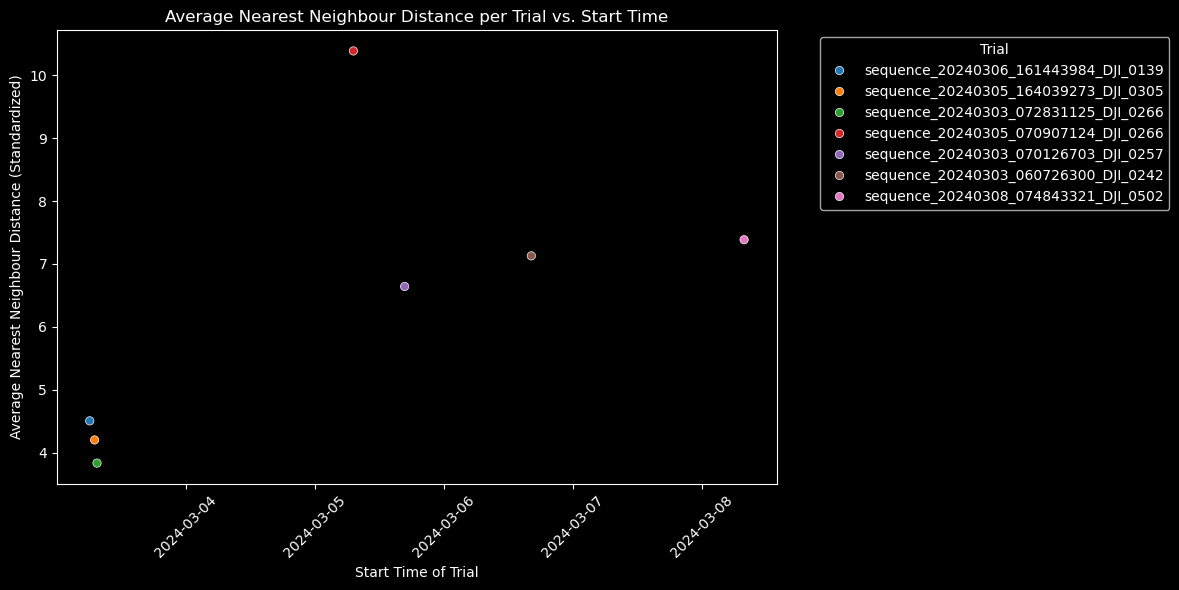

In [24]:
# Function to parse start time from the trial name
def parse_start_time(trial_name):
    date_part = trial_name.split('_')[1]
    time_part = trial_name.split('_')[2]
    # Combine date and time, ensuring correct format
    datetime_str = f"{date_part}{time_part[:6]}{time_part[6:]}"  # YYYYMMDDHHMMSSsss
    return datetime.strptime(datetime_str, '%Y%m%d%H%M%S%f')

# Calculate average NND for each trial
average_nnds = []
trial_start_times = []

for trial, trial_data in subset.groupby('Trial'):
    avg_nnd = trial_data['normalized_nnd'].mean()  # Compute the average NND for the trial
    start_time = parse_start_time(trial)  # Get the start time of the trial
    average_nnds.append(avg_nnd)
    trial_start_times.append(start_time)

# Create a DataFrame for the average NNDs and start times
avg_nnd_df = pd.DataFrame({
    'Trial': subset['Trial'].unique(),
    'avg_nnd': average_nnds,
    'start_time': trial_start_times
})

# Plot the data using seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=avg_nnd_df, 
    x='start_time', 
    y='avg_nnd', 
    hue='Trial',  # Add hue for the trial
    palette='tab10'
)

# Add labels and title
plt.xlabel('Start Time of Trial')
plt.ylabel('Average Nearest Neighbour Distance (Standardized)')
plt.title('Average Nearest Neighbour Distance per Trial vs. Start Time')
plt.legend(title='Trial', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

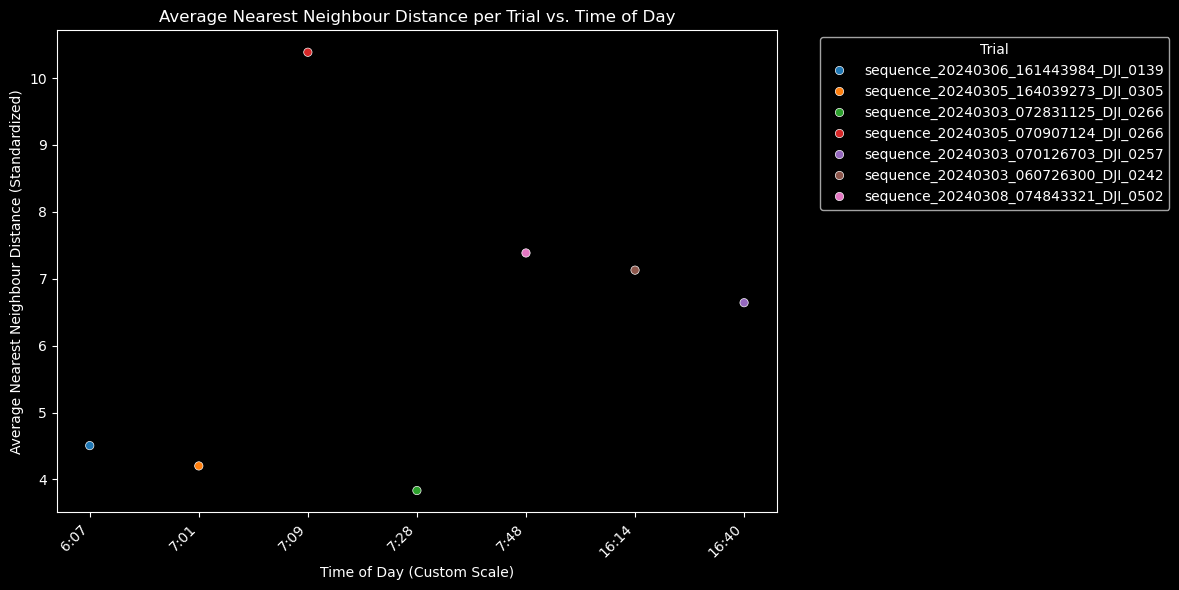

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# Function to parse the time of day from the trial name
def parse_start_time(trial_name):
    time_part = trial_name.split('_')[2]  # Extract the time from the trial name (HHMMSSsss)
    time_str = f"{time_part[:2]}:{time_part[2:4]}:{time_part[4:6]}.{time_part[6:]}"  # Format time
    return datetime.strptime(time_str, '%H:%M:%S.%f').time()  # Convert to time object

# Convert time to seconds since midnight
def time_to_seconds(time_obj):
    return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second + time_obj.microsecond / 1e6

# Calculate average nearest neighbor distance for each trial
average_nnds = []
trial_start_times = []

for trial, trial_data in subset.groupby('Trial'):
    avg_nnd = trial_data['normalized_nnd'].mean()  # Compute the average nearest neighbor distance for the trial
    start_time = parse_start_time(trial)  # Get the start time of the trial (time of day)
    average_nnds.append(avg_nnd)
    trial_start_times.append(start_time)

# Create a DataFrame for the average distances and start times
avg_nnd_df = pd.DataFrame({
    'Trial': list(subset['Trial'].unique()),  # Convert to list for consistent ordering
    'avg_nnd': average_nnds,
    'start_time': trial_start_times
})

# Convert start time to seconds for plotting
avg_nnd_df['start_time_seconds'] = avg_nnd_df['start_time'].apply(time_to_seconds)

# Custom mapping: Re-scale time
valid_seconds = avg_nnd_df['start_time_seconds'].sort_values().unique()
custom_x_mapping = {v: i for i, v in enumerate(valid_seconds)}
avg_nnd_df['custom_x'] = avg_nnd_df['start_time_seconds'].map(custom_x_mapping)

# Plot the data using seaborn
plt.figure(figsize=(12, 6))

# Scatter plot with the custom x-axis
sns.scatterplot(
    data=avg_nnd_df, 
    x='custom_x', 
    y='avg_nnd', 
    hue='Trial', 
    palette='tab10'
)

# Add labels and title
plt.xlabel('Time of Day (Custom Scale)')
plt.ylabel('Average Nearest Neighbour Distance (Standardized)')
plt.title('Average Nearest Neighbour Distance per Trial vs. Time of Day')
plt.legend(title='Trial', bbox_to_anchor=(1.05, 1), loc='upper left')

# Format the x-axis labels with original time
plt.xticks(
    ticks=range(len(valid_seconds)), 
    labels=[str(timedelta(seconds=int(t)))[:-3] for t in valid_seconds], 
    rotation=45, ha='right'
)

plt.tight_layout()
plt.show()



#### Averages

In [4]:
subset = pd.read_hdf(output_folder + "nn_sharks.h5", key='sharks')

In [5]:
subset['Trial_num']= subset['Trial'].astype('category').cat.codes

In [6]:
nn_distance_avg = subset[['carangids','normalized_nnd','Trial_num']].groupby(['carangids','Trial_num']).mean().reset_index()
nn_distance_avg

carangids  Trial_num  normalized_nnd
0           0          0        4.571718
1           0          1        4.382840
2           0          2        3.831063
3           0          3        5.744468
4           0          4       10.385061
5           0          5        7.005947
6           0          6        7.010997
7           0          7        7.601702
8           1          0        3.153611
9           1          1        2.458006
10          1          2        3.471005
11          1          5        5.461228
12          1          6        7.213210
13          1          7        5.031513

In [7]:
nn_distance_avgID = subset[['carangids','normalized_nnd','Trial_num', 'ID']].groupby(['carangids','Trial_num', 'ID']).mean().reset_index()
nn_distance_avgID

carangids  Trial_num  ID  normalized_nnd
0           0          0   0        4.421452
1           0          0   1        5.073874
2           0          0   2        4.068725
3           0          0   3        5.767552
4           0          0   4        3.894603
5           0          0   5        3.845382
6           0          1   0        4.734410
7           0          1   1        4.708237
8           0          1   2        2.690837
9           0          1   3        4.255942
10          0          2   0        3.702301
11          0          2   1        3.724565
12          0          2   2        3.885399
13          0          2   3        4.020673
14          0          3   0        6.174057
15          0          3   1        5.150969
16          0          3   2        6.162612
17          0          4   0       10.385061
18          0          4   1       10.385061
19          0          5   0        6.570100
20          0          5   1        9.242834
21          0          5   2        5.009843
22          0          6   0        6.191807
23          0          6   1        7.250871
24          0          7   0        7.616287
25          0          7   1        7.585787
26          1          0   0        3.129480
27          1          0   1        4.085105
28          1          0   2        1.886440
29          1          0   4        1.638922
30          1          1   0        2.317195
31          1          1   1        2.735347
32          1          1   2        2.219817
33          1          1   3        2.737881
34          1          2   1        2.705919
35          1          2   2        3.592935
36          1          2   3        3.271757
37          1          5   0        6.030829
38          1          5   1        5.923331
39          1          5   2        4.679062
40          1          6   0        7.481348
41          1          6   1        2.155516
42          1          7   0        2.672762
43          1          7   1        5.952067

In [8]:
nndistanceavg = subset[['carangids','normalized_nnd','Trial_num', 'segment','ID']].groupby(['carangids','Trial_num', 'segment','ID']).mean().reset_index()

C:\Users\sophi\AppData\Local\Temp\ipykernel_8156\1989571691.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='carangids',y='normalized_nnd',data = nndistanceavg, palette="Set1")


<Axes: xlabel='carangids', ylabel='normalized_nnd'>

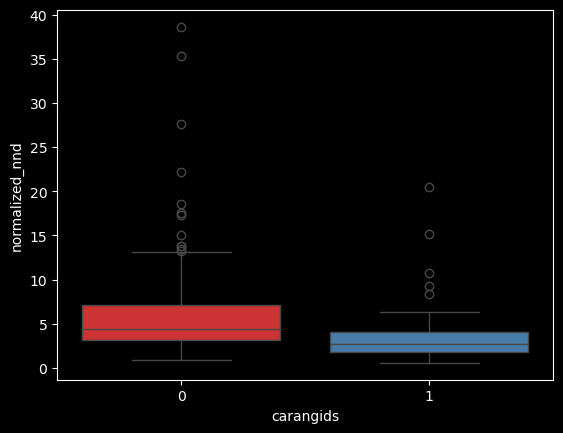

In [9]:
sns.boxplot(x='carangids',y='normalized_nnd',data = nndistanceavg, palette="Set1")

In [10]:
nndID = subset[['unique_id_count','normalized_nnd','Trial_num','ID','segment']].groupby(['unique_id_count','Trial_num','ID', 'segment']).mean().reset_index()

C:\Users\sophi\AppData\Local\Temp\ipykernel_8156\706401548.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='unique_id_count',y='normalized_nnd',data = nndID, palette='Set1')
C:\Users\sophi\AppData\Local\Temp\ipykernel_8156\706401548.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="unique_id_count", y='normalized_nnd', data=nndID, palette='Set1', marker="o", alpha=0.6, jitter=True)


<Axes: xlabel='unique_id_count', ylabel='normalized_nnd'>

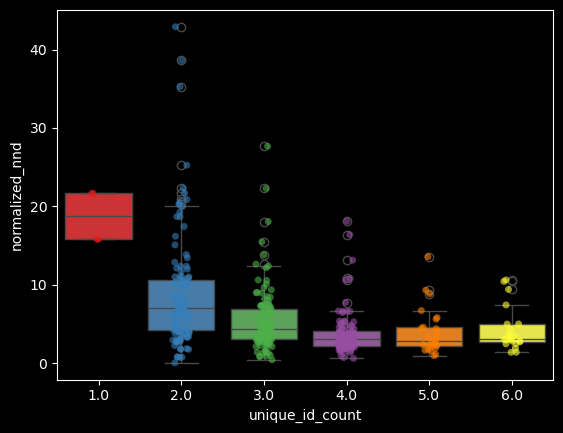

In [12]:
nndID = subset[['unique_id_count','normalized_nnd','Trial_num','ID','segment']].groupby(['unique_id_count','Trial_num','ID', 'segment']).mean().reset_index()
sns.boxplot(x='unique_id_count',y='normalized_nnd',data = nndID, palette='Set1')
# Overlay strip plot for data points with the same palette
sns.stripplot(x="unique_id_count", y='normalized_nnd', data=nndID, palette='Set1', marker="o", alpha=0.6, jitter=True)

### Logistic Regression

In [17]:
df = pd.read_hdf(output_folder + "nn_sharks.h5", key='sharks')
df.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0   2051        82.087409   0   606.844014  -396.939687 -0.435146   2051   
1   2052        76.964699   0   608.723694  -396.273295 -0.456252   2052   
2   2053        75.903308   0   610.451965  -395.569743 -0.479337   2053   
3   2054        71.775297   0   612.184855  -394.984894 -0.500498   2054   
4   2055        81.043147   0   613.870341  -394.378459 -0.521608   2055   

    time        headx        heady  ...  drone_movement  ID_checked  \
0  40.91  3172.583333  1069.333333  ...               0         1.0   
1  40.93  3174.333333  1068.916667  ...               0         1.0   
2  40.95  3175.916667  1068.416667  ...               0         1.0   
3  40.97  3177.416667  1067.916667  ...               0         1.0   
4  40.99  3178.833333  1067.500000  ...               0         1.0   

   delta_time  speed  smoothed_body_length  standardized_speed  \
0         NaN    NaN            109.851996                 NaN   
1         NaN    NaN            110.187803                 NaN   
2         NaN    NaN            110.539454                 NaN   
3         NaN    NaN            110.882277                 NaN   
4         NaN    NaN            111.196668                 NaN   

   nearest_neighbor  nn_distance  mean_body_length  normalized_nnd  
0                 1   696.033544        108.149438        6.435850  
1                 1   698.254526        108.313050        6.446633  
2                 1   700.389238        108.468860        6.457054  
3                 1   702.533543        108.648260        6.466128  
4                 1   704.553259        108.808531        6.475166  

[5 rows x 43 columns]

(array([4.21775e+05, 1.38736e+05, 2.81630e+04, 8.53400e+03, 2.31500e+03,
        2.16400e+03, 2.21300e+03, 1.54100e+03, 5.08000e+02, 7.40000e+01]),
 array([5.38896508e-03, 5.57815313e+00, 1.11509173e+01, 1.67236814e+01,
        2.22964456e+01, 2.78692098e+01, 3.34419739e+01, 3.90147381e+01,
        4.45875023e+01, 5.01602664e+01, 5.57330306e+01]),
 <BarContainer object of 10 artists>)

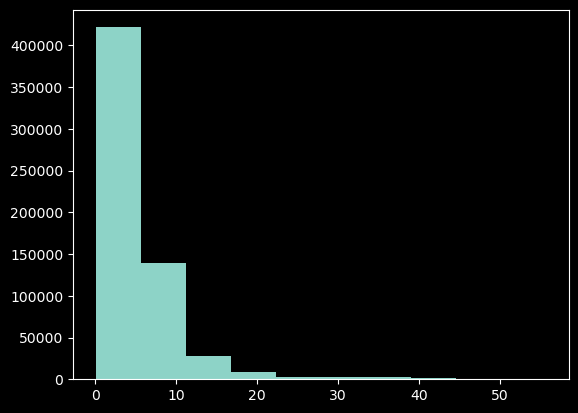

In [18]:
plt.hist(df['normalized_nnd'])

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
scaler = StandardScaler()
df['normalized_nnd_scaled']=scaler.fit_transform(df[['normalized_nnd']])

(array([4.21775e+05, 1.38736e+05, 2.81630e+04, 8.53400e+03, 2.31500e+03,
        2.16400e+03, 2.21300e+03, 1.54100e+03, 5.08000e+02, 7.40000e+01]),
 array([-1.01499884,  0.08919275,  1.19338434,  2.29757593,  3.40176752,
         4.50595911,  5.6101507 ,  6.71434229,  7.81853388,  8.92272547,
        10.02691706]),
 <BarContainer object of 10 artists>)

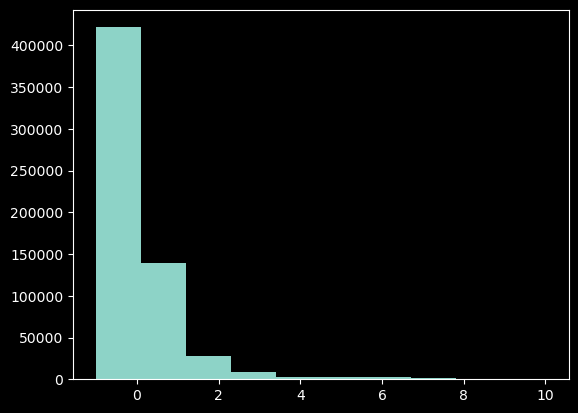

In [21]:
plt.hist(df['normalized_nnd_scaled'])

In [13]:
# Group by both 'ID' and 'segment' and count the number of frames for each group
id_segment_counts = df.groupby(['ID', 'segment','Trial']).size()

# Filter out ID-segment combinations that have less than 100 frames (2 seconds)
id_segments_to_keep = id_segment_counts[id_segment_counts >= 200].index

# Keep only the rows where the combination of 'ID' and 'segment' is in the list of groups with >= 100 frames
df_filtered = df[df.set_index(['ID', 'segment','Trial']).index.isin(id_segments_to_keep)]

#### segments

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load dataset (assuming df is your DataFrame)
df = df.copy()

# Ensure relevant columns are present
relevant_columns = ['ID', 'frame', 'headx', 'heady', 'lxfinx', 'lxfiny', 'btipx', 'btipy', 
                    'rxfinx', 'rxfiny', 'pelvicfinx', 'pelvicfiny', 'sdfinx', 'sdfiny',
                    'pedunclex', 'peduncley', 'finx', 'finy', 'ttipx', 'ttipy', 
                    'segment', 'Trial', 'midpoint_x', 'midpoint_y', 'normalized_nnd']

df = df[relevant_columns].dropna()  # Remove NaNs

# ✅ Create movement-based features (frame differences)
for col in ['headx', 'heady', 'lxfinx', 'lxfiny', 'btipx', 'btipy', 'rxfinx', 'rxfiny', 
            'pelvicfinx', 'pelvicfiny', 'sdfinx', 'sdfiny', 'pedunclex', 'peduncley', 
            'finx', 'finy', 'ttipx', 'ttipy', 'midpoint_x', 'midpoint_y', 'normalized_nnd']:
    df[f"{col}_diff"] = df[col] - df[col].shift(1)

# ✅ Labeling (Same Segment = 1, Random = 0)
df['same_segment'] = (df['segment'] == df['segment'].shift(1)).astype(int)

# Remove NaNs from shift operation
df = df.dropna()

# Define features & target
feature_columns = [col for col in df.columns if '_diff' in col]  # Only movement-based features
X = df[feature_columns]
y = df['same_segment']

# ✅ Split data into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ✅ Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

# ✅ Make Predictions
y_pred = model.predict(X_test)

# ✅ Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)


Accuracy: 0.9988
Confusion Matrix:
 [[     0    149]
 [     0 121049]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       149
           1       1.00      1.00      1.00    121049

    accuracy                           1.00    121198
   macro avg       0.50      0.50      0.50    121198
weighted avg       1.00      1.00      1.00    121198



C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

#### with carangids

Epoch 1/10


C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 56s 9s/step - accuracy: 0.7938 - loss: nan - val_accuracy: 0.7556 - val_loss: nan
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.7707 - loss: nan - val_accuracy: 0.7556 - val_loss: nan
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.7804 - loss: nan - val_accuracy: 0.7556 - val_loss: nan
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 54s 9s/step - accuracy: 0.7747 - loss: nan - val_accuracy: 0.7556 - val_loss: nan
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 55s 9s/step - accuracy: 0.7603 - loss: nan - val_accuracy: 0.7556 - val_loss: nan
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 57s 9s/step - accuracy: 0.7888 - loss: nan - val_accuracy: 0.7556 - val_loss: nan
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 55s 9s/step - accuracy: 0.7758 - loss: nan - val_accuracy: 0.7556 - val_loss: nan
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 56s 9s/step - accuracy: 0.7681 - loss: nan - val_accuracy: 0.7556 - val_loss: nan
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 55s 9s/step - accuracy: 0.7621 

C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

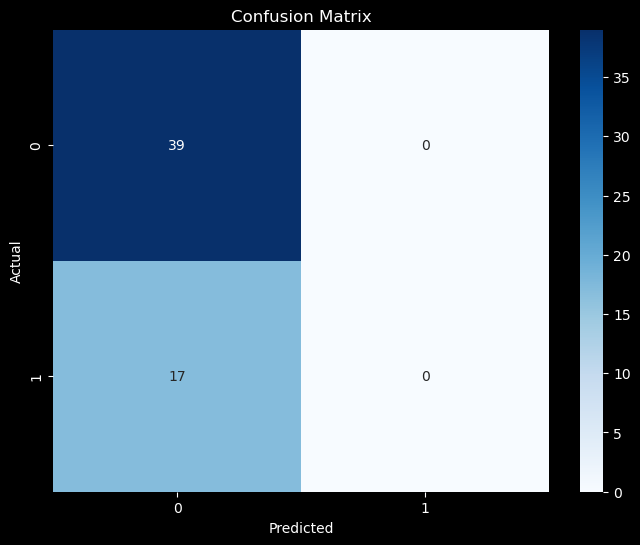

C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NameError: name 'TimeDistributed' is not defined

In [16]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Create time-series data
sequence_data = []
targets = []

for trial_id, trial_df in df_filtered.groupby(['ID', 'Trial', 'segment', 'carangids']):
    speeds = trial_df['normalized_nnd'].values
    target = trial_df['carangids'].iloc[0]  # Assuming target is consistent per trial
    sequence_data.append(speeds)
    targets.append(target)

# Padding sequences to ensure uniform length
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = max(len(seq) for seq in sequence_data)
X = pad_sequences(sequence_data, maxlen=max_len, padding='post', dtype='float32')
y = np.array(targets)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM Model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_len, 1)),  # Handle padded values
    LSTM(50, activation='tanh', return_sequences=False),  # Adjust units as needed
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape data for LSTM (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Generate predictions
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example: Create time-series data
sequence_data = []
targets = []

for trial_id, trial_df in df_filtered.groupby(['ID', 'Trial', 'segment', 'carangids']):
    speeds = trial_df['normalized_nnd'].values
    target_sequence = trial_df['carangids'].values  # Full target sequence
    sequence_data.append(speeds)
    targets.append(target_sequence)

# Padding sequences for both inputs and outputs
max_len = max(len(seq) for seq in sequence_data)
X = pad_sequences(sequence_data, maxlen=max_len, padding='post', dtype='float32')
y = pad_sequences(targets, maxlen=max_len, padding='post', dtype='int')  # Ensure binary targets are padded

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for LSTM (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Build LSTM Model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_len, 1)),  # Handle padded values
    LSTM(50, activation='tanh', return_sequences=True),  # Return sequences for multi-frame output
    TimeDistributed(Dense(1, activation='sigmoid'))  # Predict binary output for each frame
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Generate predictions
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Flatten the outputs for evaluation
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_binary.flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred_flat))

# Confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
